# <center> Batch Analysis of Cosmic Rays Using Drift Tubes Detectors </center>
## <center> Management and Analysis of Physics Datasets </center>
<center> Maria Camila Paris Diaz, Laura Marie Schulze, Lorenzo Martinelli

The aim of this project is to utilize real-life data to reconstruct the tracks of cosmic rays crossing through a series of drift chamber detectors installed in Legnaro (PD). Throughout the notebook, we highlight how the data has been handled and unpacked from its non-trivial, initial binary state (useful to save space) all the way to the reconstruction of tracks both within one single chamber, which we name "local tracks", as well as tracks spanning multiple chambers, which we name "global tracks".<br>
In order to facilitate this analysis, we use three virtual machines provided by CloudVeneto. These machines work together to form a cluster, which is managed thanks to **Dask**.

## Setup
In this first section of the notebook, we import the necessary libraries which will be used throughout the analyses, and we set up the cluster with Dask. At this stage, we are not interested in any particular specifics of the cluster (we will analyze them more in depth in another notebook), so for the time being we use just the default options of setting up the cluster.

In [1]:
# General utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy.optimize import curve_fit

# Dask and Dask-adjacent libraries
from distributed import Client
from distributed import SSHCluster
from dask import delayed
import dask.array as da
import dask.dataframe as dd
import dask.bytes

# Other libraries
import os
from typing import Tuple

np.random.seed(13)

In [2]:
# Set-up the Dask Cluster
# At this point, we are not tinkering with the options on workers
cluster = SSHCluster(['10.67.22.72', '10.67.22.72', 
                      '10.67.22.180', '10.67.22.235'],
                    connect_options = {'username': 'parisdiaz', 
                                       'password': 'VI?tl51kh', 
                                       'known_hosts': None},
                    scheduler_options = {'port': 8787, 
                                  'dashboard_address': ':8797'})

2025-02-07 11:20:51,452 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:51,451 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-02-07 11:20:51,481 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:51,480 - distributed.scheduler - INFO - State start
2025-02-07 11:20:51,483 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:51,481 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_kxv9n07', purging
2025-02-07 11:20:51,487 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:51,486 - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.72:8787
2025-02-07 11:20:52,013 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:52,012 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.72:46821'
2025-02-07 11:20:52,038 - distributed.deploy.ssh - INFO - 2025-02-07 11:20:52,040 - distributed.nanny - INFO -    

In [3]:
# Check if the cluster was set up properly
client = Client(cluster)
client

<Client: 'tcp://10.67.22.72:8787' processes=0 threads=0, memory=0 B>

To check if the cluster has been properly set up, we use this extremely simple task, which would be very time consuming to run on a single machine.

In [4]:
# Test on a very simple task
array = da.random.random((10000, 10000), chunks = (1000, 1000))
result = array.sum().compute()
print(result)

49999146.26664152


## Unpacking Data
The first part in this data analysis project deals with... well, obtaining the data. Luckily for us, it was already provided, so our only task here is to unpack it from its binary, `.dat` format to one that is more simple to use.

In [5]:
@delayed
def unpack_binary_word(b_word: bytes, 
                       big_endian: bool = False) -> pd.DataFrame:
    """
    This function unpacks a binary word following the convention
    used in the experiment
    
    Args:
        b_word (bytes): The raw binary data word that has to be
                        unpacked.
        big_endian (bool): A boolean flag, if True reads the 
                           data in the big endian convention,
                           otherwise in the little endian one.
                           Default is False
                           
    Returns:
        pd.DataFrame: A DataFrame containing the unpacked binary word,
                      neatly ordered
    
    """
    
    dt = np.dtype(np.uint64)
    if big_endian:
        dt = dt.newbyteorder('>')     # Big endian
    else:
        dt = dt.newbyteorder('<')     # Little endian
    word = np.frombuffer(b_word, dtype = dt)
    
    head = (word >> 61) & 0x7          
    fpga = (word >> 58) & 0x7          
    chan = (word >> 49) & 0x1FF        
    orbit = (word >> 17) & 0xFFFFFFFF  
    bx = (word >> 5) & 0xFFF           
    tdc = word & 0x1F                  
    return pd.DataFrame({
        'TDC': tdc,
        'BX': bx,
        'ORBIT': orbit,
        'CHAN': chan,
        'FPGA': fpga,
        'HEAD': head
    })
    
def read_files(file_path: str) -> dd.DataFrame:
    """
    This function reads all the files in the path using 
    dask.bytes.read_bytes, then unpacks them and creates a Dask 
    DataFrame. It uses the function unpack_binary_word to unpack
    the binary files
    
    Args:
        file_path (str): A string indicating the path to the 
                         file(s)
    
    Returns:
        ddf (dd.DataFrame): A Dask DataFrame built using the 
                            file(s).
    
    """    
    
    _, blocks = dask.bytes.read_bytes(file_path,
                                      key = '<INSERT PUBLIC KEY>',
                                      secret = '<INSERT PRIVATE KEY>',
                                      client_kwargs = {
                                         'endpoint_url': 'https://cloud-areapd.pd.infn.it:5210',
                                         'verify': False
                                      })
    ddf_del = [unpack_binary_word(block[0]) for block in blocks]
    ddf = dd.from_delayed(ddf_del)
    return ddf

file_path_pattern = 's3://mapd-minidt-batch/*.dat'
ddf = read_files(file_path_pattern)

# inspect unpacked data
ddf.head()

,TDC,BX,ORBIT,CHAN,FPGA,HEAD
0,0,0,4079645633,100,1,1
1,2,4064,4079645602,100,1,0
2,23,1476,4079645568,100,1,4
3,16,653,4079645568,100,1,5
4,2,2922,3387200947,75,0,2


## Filtering Data and Mapping Detectors
Now, we filter the obtained DataFrame based on its `HEAD` column: if `HEAD == 2` then the data is associated to
TDC hits and thus useful to us, otherwise it is ancillary data and has to be scrapped. <br>
The next step is to map the chambers properly. In order to do so, we follow the scheme: <br>
* `FPGA == 0`, `CHAN in range(0, 64)`: Chamber 0
* `FPGA == 0`, `CHAN in range(64, 128)`: Chamber 1
* `FPGA == 1`, `CHAN in range(0, 64)`: Chamber 2
* `FPGA == 1`, `CHAN in range(64, 128)`: Chamber 3

Additionally, there is a handful of events where `CHAN == 138`. These events also need to be filtered out, as they provide an additional type of information whose utility is outside the scope of this project.

In [6]:
ddf = ddf.repartition(npartitions = 12)

In [7]:
ddf = ddf[ddf['HEAD'] == 2]
ddf = ddf[ddf['CHAN'] != 138]

In [8]:
# Map chambers & layers
def determine_chamber(fpga: int, chan: int) -> int:
    """
    Associates a chamber given the value in the field 'fpga' and 
    'chan' (channel)
    
    Args:
        - fpga (int): A number (either 0 or 1), describing which 
                      FPGA is used by the cell.
        - chan (int): A number (from 0 to 127), describing which
                      channel is used by the cell.
        BOTH FPGA AND CHAN ARE USED TO DETERMINE THE CHAMBER THE
        CELL BELONGS TO
    
    Returns:
        int: A number (from 0 to 3), determining the chamber.
             0 is the bottom-most chamber, while 3 is the 
             top-most.
    """
    
    if fpga == 0:
        if chan in range(0, 64):
            return 0
        elif chan in range(64, 128):
            return 1
    elif fpga == 1:
        if chan in range(0, 64):
            return 2
        elif chan in range(64, 128):
            return 3
    return '-1'

def map_chamber_and_layer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the determine_chamber() function in a vectorized 
    fashion and also defines the layer of the cell. Each cell 
    has 4 layers, and the simple relation between channel 
    and layer is:
    layer = channel % 4
    
    Args:
        df (pd.DataFrame): Pandas DataFrame containing the data 
                           (in this case, specifically the
                            'FPGA' and 'CHAN' fields)
    
    Returns:
        df (pd.DataFrame): The same DataFrame, but now with the 
                           added columns 'chamber' and 'layer'
    
    """
    
    
    df['chamber'] = np.vectorize(determine_chamber)(df['FPGA'], df['CHAN'])
    df['layer'] = df['CHAN'] % 4
    return df

ddf = ddf.map_partitions(map_chamber_and_layer)

## Adding Hit Information
After some preliminary work, we are now ready to add the hit information. This requires the following steps:

1. Computing the TDC hit time information $t_{\textrm{hit}}$. It is obtained with the equation the equation $t_{\textrm{hit}} = 25 \times \bigg[ (\textrm{ORBIT} \times 3564) + \textrm{BX} + \frac{\textrm{TDC}}{30} \bigg] \textrm{ns}$
2. Getting the reference time $t_0$ for each orbit from the scintillator hits, using the same equation and taking delays into account.
3. Compute the hit coordinate $x_\text{hit}$ for each TDC hit using the equation $x_{\textrm{hit}} = \big( t_{\textrm{hit}} - t_0 \big) v_{\textrm{drift}}$,  with a constant drift velocity $v_\text{drift}$.


**Step 1:** Computing Hit time information. Both TDC and scintillator hit times in ns are computed according to the formula above. Additionally, an `extra_delay_ns` column is added to take into account some chamber-specific effects.

In [9]:
extra_delay = {
    0: - 1.1,
    1: 6.4,
    2: 0.5,
    3: -2.6
}

# add chamber-specific extra delay to dataframe
ddf['extra_delay_ns'] = ddf['chamber'].map_partitions(lambda x: x.map(extra_delay))

# compute absolute hit time in ns
ddf['abs_time_ns'] = 25 * ( (ddf['ORBIT'] * 3564) + ddf['BX'] + (ddf['TDC'] / 30) )


**Step 2:** Computing reference time $t_0$. <br> 
The TDC hits will be grouped by orbit, and to facilitate track reconstructions, only orbits where a single scintillator hit has been detected are used. For each of these orbits the $t_0$ computed from the scintillator hit is assigned as reference to all TDC hits in that orbit, excluding those that occured before $t_0$. <br>

First, we seperate TDC hits and scintillator hits:

In [10]:
# separate scintillator and TDC hits
ddf_sci = ddf[ddf['CHAN'] == 128]
ddf_tdc = ddf[ddf['CHAN'] != 128]

Then we find all of the orbits in which only a single scintillator hit occurs:

In [11]:
# count scintillator hits per orbit
sci_counts = ddf_sci.groupby('ORBIT').size().compute().reset_index(name='sci_count')

# filter to get orbits with a single scintillator hit
single_hit_orbits = sci_counts[sci_counts['sci_count'] == 1]['ORBIT']

The scintillator/TDC DataFrames are filtered and merged accordingly:

In [12]:
# filter scintillator/TDC hits to keep only single-hit orbits
single_hit_sci = ddf_sci[ddf_sci['ORBIT'].isin(single_hit_orbits)]
single_hit_tdc = ddf_tdc[ddf_tdc['ORBIT'].isin(single_hit_orbits)]

# merge dataframes
det_with_t0 = dd.merge(single_hit_tdc, single_hit_sci[['ORBIT', 'abs_time_ns']],
                       on = 'ORBIT',
                       suffixes = ('', '_sci'))

Using the previously calculated scintillator hit times in ns, we now take the delay of 95 ns as well as the chamber-specific `extra_delay_ns` into account to calculate $t_0$.

In [13]:
# compute t0
det_with_t0['t0'] = det_with_t0['abs_time_ns_sci'] - (95 + det_with_t0['extra_delay_ns'])

**Step 3:** Computing $x_{\textrm{hit}}$ according to 
$$
x_{\textrm{hit}} = \big( t_{\textrm{hit}} - t_0 \big) v_{\textrm{drift}}
$$
using the constant drift velocity $v_\text{drift} = 53.8$ μm/ns. <br>
From this point, we are also interested in using only the hits which are actually related to the crossing of a cosmic ray. Coming up with a refined way to scrap out hits is outside the scope of this project, and something which would require a deeper knowledge of the detectors themselves. So we based our filtering on one key assumption: Scintillator hits (with the delay correction) always happen before the corresponding hit in the drift chamber. This way, we are able to define a time window *after* the scintillator hit which corresponds to real hits. The estimated time window is based on the cell size.

In [14]:
v_drift = 53.8/1000  # [mm/ns]
Delta_t = 21 / v_drift  # [ns]

# Check if the corrected time of the event is in the interval
# Keep only events that fall in the "valid" time frame
ddf_x_hit = det_with_t0[det_with_t0['abs_time_ns'].between(det_with_t0['t0'], det_with_t0['t0'] + Delta_t)]

# Compute x_hit
ddf_x_hit['x_hit_mm'] = v_drift * (det_with_t0['abs_time_ns'] - det_with_t0['t0'])

Now that we have the hit coordinates within each cell, we need to take the cell position within the chamber into account:

In [15]:
# include cell position within the chamber based on channel
def get_chamber_position(df: pd.DataFrame) -> pd.DataFrame:
    """
    Determines the coordinates of the center of a given cell (both
    horizontally and vertically), as well as the horizontal 
    coordinates of the left and right hits that happened within
    a cell.
    For this function, the relevant fields of the input DataFrame are
    'CHAN' and 'x_hit_mm'
    
    Args:
        df (pd.DataFrame): Pandas DataFrame containing the hit
                           information.
    Returns:
        df (pd.DataFrame): The same DataFrame, now with hit
                           information added.
    
    """
    
    # This list is used to check which condition in the 'CHAN' 
    # field is verified (i.e., which layer is being used)
    conditions = [
        (df['CHAN'] % 4 == 0),
        (df['CHAN'] % 4 == 1),
        (df['CHAN'] % 4 == 2),
        (df['CHAN'] % 4 == 3)
    ]

    # This list is used to add the x-coordinate of the center
    # of the cell, based on the conditions list
    choices_x = [
        21 + 42 * (df['CHAN'] // 4),
        21 + 42 * (df['CHAN'] // 4),
        42 + 42 * (df['CHAN'] // 4),
        42 + 42 * (df['CHAN'] // 4)
    ]

    
    # This list is used to add the z-coordinate of the center
    # of the cell, based on the conditions list
    choices_z = [
        3.5 * 13,
        1.5 * 13,
        2.5 * 13,
        0.5 * 13
    ]

    df['x_chamber_center'] = np.select(conditions, choices_x)
    df['z_loc'] = np.select(conditions, choices_z)
    df['x_right_loc'] = df['x_chamber_center'] + df['x_hit_mm']
    df['x_left_loc'] = df['x_chamber_center'] - df['x_hit_mm']

    return df

In [16]:
# adjust channels so that they are assigned the right number
ddf_x_hit['CHAN'] = ddf_x_hit['CHAN'].where(ddf_x_hit['CHAN'] <= 63, 
                                            ddf_x_hit['CHAN'] - 64)

# apply the function
ddf_x_hit = ddf_x_hit.map_partitions(get_chamber_position)

To check, we plot the coordinates for an example orbit:

In [17]:
# plotting function
def plot_local(df: pd.DataFrame):
    """
    This function plots the cells interested by an event,
    plotting the center of said cells, the left, and the
    right position of the hits. It also plots nearby cells.
    
    Args:
        df (pd.DataFrame): DataFrame containing the spacial
                           information about an event 
                           (i.e., its coordinates)
    
    """
    
    fig, ax = plt.subplots(figsize = (20, 5))

    ax.scatter(df['x_chamber_center'], df['z_loc'])
    ax.scatter(df['x_left_loc'], df['z_loc'],
                marker = 'x', color = 'tab:orange')
    ax.scatter(df['x_right_loc'], df['z_loc'],
                marker = 'x', color = 'tab:orange')

    # boundaries with hlines and vlines
    for i in range(5):
        ax.axhline(13*i, color='grey')
    # vertical:
    for j in range(17):
        ax.vlines(x=42*j, ymin=13, ymax=26, color="grey")
        ax.vlines(x=42*j, ymin=39, ymax=52, color="grey")
        ax.vlines(x=21+42*j, ymin=0, ymax=13, color="grey")
        ax.vlines(x=21+42*j, ymin=26, ymax=39, color="grey")

    # plot labels, etc...
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_xlim(df['x_left_loc'].min() - 42, df['x_right_loc'].max() + 42)

    plt.show()

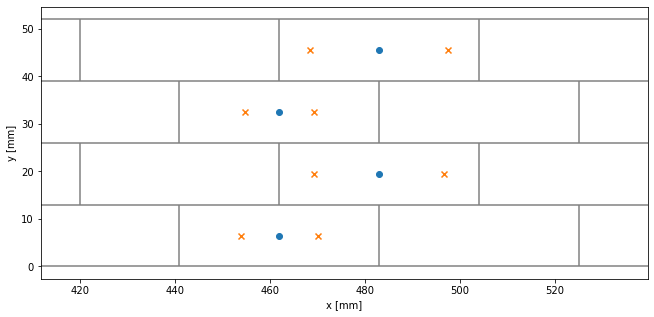

In [18]:
# plot example subset
ddf_subset = ddf_x_hit[ddf_x_hit['ORBIT'] == 1339572][ddf_x_hit['chamber'] == 3].compute()
plot_local(ddf_subset)

## Local Track Reconstruction
Now it is time to finally reconstruct the local tracks by performing a linear fit on the hit coordinates. Due to the way the drift chambers work, we have to take into account that a left/right ambiguity is introduced and that we have to select the best combination of left/right coordinates for all hits. <br>
We tackled this with an algebraic approach: By using the `lstsq()` function of the `numpy.linalg` package, we are able to perform the fits for all possible combinations rather quickly taking advantage of the streamlined handling of algebraic objects `numpy` was made for. <br>
Then, the combination which yields the smallest reduced $\chi^2$ is chosen.<br>
To do so, we create a 2D array `x`  with all possible x_left/x_right combinations and a coefficient matrix `A` with the z-values and ones, such that we can solve $$A\cdot\beta=x$$ with $\beta$ containing the slope and intercept coefficients for all combinations. <br>
To facilitate calculations, we limited the fits to those cases where we have 3 or 4 hits in at least 3 layers. Events with only 2 hits are impossible for us to properly reconstruct, since a least square fit in that case would always have no residuals whatsoever (as Euclid's first axiom of geometry taught us more than 2300 years ago). <br>

In [19]:
def remove_outliers_b(xs: list, threshold: float = 4*42, k: int = 2):
    """
    Returns a boolean mask where True indicates the point is NOT an outlier.
    A point is considered an outlier if at least `k` of its pairwise distances exceed the `threshold`.
    
    Args:
        xs (list): List containing horizontal coordinates
        threshold (float): distance (in mm) threshold for keeping hits. 
                           If the distance between the centers is higher than this threshold, 
                           then the point is suspect. Defaults to 4*42 = 168
        k (int): Number of suspect points allowed. If more than k hits are suspect, then the
                 hit is discarded. Defaults to 2.
    """
    xs = np.array(xs, dtype=float)  # Ensure float for safe subtraction
    differences = np.abs(xs[:, None] - xs)  # Compute pairwise distances

    # Count how many distances exceed the threshold for each point
    count_exceeding = np.sum(differences > threshold, axis=1)

    # Return True for non-outliers (when fewer than k distances exceed the threshold)
    return count_exceeding < k

In [20]:
def fit_local(df: pd.DataFrame, threshold: float =4*42) -> pd.DataFrame:
    """
    This function performs a fit of the local trajectory (i.e., 
    the trajectory within a single chamber) taken by a cosmic ray
    through the least-squares algorithm, so under the assumption
    that the trajectory is a straight line.
    It actually performs ALL the possible fits in a vectorized 
    fashion, then it chooses the best one based on 
    the chi-square (chooses the one with the lowest value).
    
    Args:
        df (pd.DataFrame): DataFrame containing the relevant
                           information to reconstruct a 
                           trajectory.
        threhsold (float): A threshold on the spatial distance
                           (in mm), as seen in the 
                           remove_outliers_b function. 
                           Defaults to 4*42 = 168
    
    Returns:
        pd.DataFrame: DataFrame with the information about the 
                      trajectory: coordinates of the hit,
                      slope, intercept, etc...; as well as the
                      chi-square associated with said trajectory
    """
    # remove outliers
    df_cl = df[remove_outliers_b(df['x_chamber_center'], threshold=threshold)]
    
    # Get events with at least 3 hits from at least 3 different layers
    if df_cl.shape[0] in (3, 4) and len(np.unique(df_cl['layer'])) >= 3:
        
        # Get the left and right hit positions, as well as th
        # vertical positions
        x_left = np.array(df_cl['x_left_loc'].values)
        x_right = np.array(df_cl['x_right_loc'].values)
        z = np.array(df_cl['z_loc'].values)
        
        stack = np.column_stack((x_left, x_right))   # Stacks the arrays in a N x 2 array (useful later on)
        x = np.array(np.meshgrid(*stack)).reshape(df_cl.shape[0] ,-1) # Get all possible left-right combinations for each cell involved
        
        
        A = np.vstack((z, np.ones(np.shape(z)))).T   # Get a matrix for the least squares
        
        # Least squares: save coefficients and residuals
        coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond = None)
        
        red_chi2 = residuals / (df_cl.shape[0] - 2 + 1e-10)  # Compute the chi-square (add a small constant to avoid division by zero)
        choice = np.argmin(red_chi2)                      # Choose the index which minimizes the chi-square
        
        # Use choice index to select the best fit
        best_red_chi2 = red_chi2[choice]
        slope = coeffs[0][choice]
        intercept = coeffs[1][choice]
        x_best = x.T[choice]
        
        result = pd.DataFrame({
            'ORBIT': [df_cl['ORBIT'].iloc[0]],
            'chamber': [df_cl['chamber'].iloc[0]],
            'x_chamber_center': [df_cl['x_chamber_center'].values],
            'x_left_loc': [x_left],
            'x_right_loc': [x_right],
            'x_best': [x_best],
            'z_loc': [z],
            'slope': [slope],
            'intercept': [intercept],
            'reduced_chi2': [best_red_chi2]
        })
        
        return result
    
    # Return an empty DataFrame if the conditions aren't met
    else:
        return pd.DataFrame(columns = ['ORBIT', 'chamber',
                                       'x_chamber_center',
                                       'x_left_loc', 'x_right_loc',
                                       'x_best', 'z_loc',
                                       'slope', 'intercept', 
                                       'reduced_chi2'])

In [21]:
meta = {
    'ORBIT': 'int32',
    'chamber': 'int32',
    'x_chamber_center': 'object',
    'x_left_loc': 'object',
    'x_right_loc': 'object',
    'x_best': 'object',
    'z_loc': 'object',
    'slope': 'float32',
    'intercept': 'float32',
    'reduced_chi2': 'float32'}

groups = ddf_x_hit.groupby(['ORBIT', 'chamber']).apply(fit_local, 
                                                       threshold=42,
                                                       meta = meta)

result_local_df = groups.compute()

result_local_df.reset_index(drop = True, inplace = True)

In [22]:
result_local_df.head()

,ORBIT,chamber,x_chamber_center,x_left_loc,x_right_loc,x_best,z_loc,slope,intercept,reduced_chi2
0,1130581,1,"[483, 504, 504]","[482.29701420898436, 499.6655133880615, 492.35...","[483.70298579101564, 508.3344866119385, 515.64...","[483.70298579101564, 499.6655133880615, 492.35...","[19.5, 6.5, 32.5]",-0.281071,497.389601,101.001271
1,1130581,2,"[504, 483, 504, 483]","[503.7041, 478.4449330596924, 498.3241, 469.1196]","[504.2959, 487.5550669403076, 509.6759, 496.8804]","[503.7041, 487.5550669403076, 498.3241, 496.8804]","[32.5, 19.5, 6.5, 45.5]",0.090907,494.252330,64.173003
2,1130581,3,"[651, 651, 672]","[650.1087142089843, 643.9217133880616, 663.397...","[651.8912857910157, 658.0782866119384, 680.602...","[651.8912857910157, 643.9217133880616, 663.397...","[19.5, 45.5, 6.5]",-0.471825,664.315301,16.162880
3,1252229,1,"[462, 483, 441, 462]","[453.7650133880615, 467.50201256713865, 430.43...","[470.2349866119385, 498.49798743286135, 451.56...","[453.7650133880615, 467.50201256713865, 451.56...","[32.5, 19.5, 45.5, 6.5]",-0.676158,479.860308,12.221072
4,1252229,2,"[525, 525, 546]","[522.0589330596924, 516.5892661193848, 529.877...","[527.9410669403076, 533.4107338806152, 562.122...","[527.9410669403076, 533.4107338806152, 529.877...","[19.5, 45.5, 32.5]",0.210372,523.572828,0.424501


In [23]:
def plot_local_fit(df: pd.DataFrame):
    """
    Plots the fit of a local trajectory.
    
    Args:
        df (pd.DataFrame): DataFrame containing the trajectory
                           information
    
    """

    # plot including fit
    fig, ax = plt.subplots(figsize=(20,5))

    
    ax.scatter(np.array(df['x_chamber_center']), np.array(df['z_loc']))
    ax.scatter(np.array(df["x_left_loc"]), np.array(df["z_loc"]),
               marker='x', color='tab:orange')
    ax.scatter(np.array(df['x_right_loc']), np.array(df['z_loc']),
              marker = 'x', color = 'tab:orange')

    # draw the channel boundaries with hlines and vlines
    # horizontal:
    ax.hlines(0, xmin=21, xmax=693, color='grey')
    ax.hlines(52, xmin=0, xmax=672, color='grey')
    for i in range(1, 4):
        ax.hlines(13*i, xmin=0, xmax=693, color='grey')
    # vertical:
    for j in range(17):
        ax.vlines(x=42*j, ymin=13, ymax=26, color="grey")
        ax.vlines(x=42*j, ymin=39, ymax=52, color="grey")
        ax.vlines(x=21+42*j, ymin=0, ymax=13, color="grey")
        ax.vlines(x=21+42*j, ymin=26, ymax=39, color="grey")

    # plot linear fit result
    z_fit = np.arange(0, 53) # generate z values
    x_fit = df["slope"]*z_fit + df["intercept"] # calculate x values from fit params
    ax.plot(x_fit, z_fit, color="tab:green")


    # set labels etc
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    ax.set_aspect('equal', adjustable='box')
    #ax.set_xlim(min(x_fit)-42, max(x_fit)+42)
    ax.set_xlim(min(min(x_fit), min(df['x_left_loc']))-42, max(max(x_fit), max(df['x_right_loc']))+42)
    ax.set_title(f"Orbit: {int(df['ORBIT'])}, Chamber: {int(df['chamber'])}")
    
    plt.show()

Check the results by looking at the distribution of the reduced $\chi^2$ values:

In [24]:
# check the chi^2 
result_local_df["reduced_chi2"].describe()

count    77998.000000
mean         3.485303
std         16.132575
min          0.000000
25%          0.127436
50%          0.364972
75%          0.932528
max        665.448701
Name: reduced_chi2, dtype: float64

In [25]:
# check stats of high chi^2
result_local_df[result_local_df["reduced_chi2"]>30].describe()

,slope,intercept,reduced_chi2
count,2355.000000,2355.000000,2355.000000
mean,0.056489,461.754479,73.551835
std,0.473824,110.064336,56.222873
min,-2.803053,-3.930090,30.006715
25%,-0.181573,425.039881,39.951077
50%,0.031972,471.912653,56.400673
75%,0.286631,522.400240,84.674208
max,2.706483,695.411475,665.448701


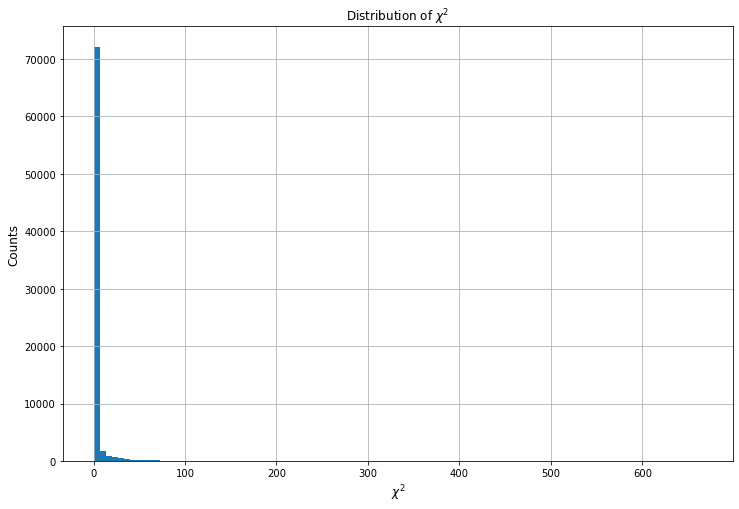

In [26]:
# plot chi^2 distribution
plt.figure(figsize = (12, 8))
plt.hist(result_local_df['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

To get a better look at the distribution, we filter the results for $\chi^2 < 30$ to exclude large outliers.

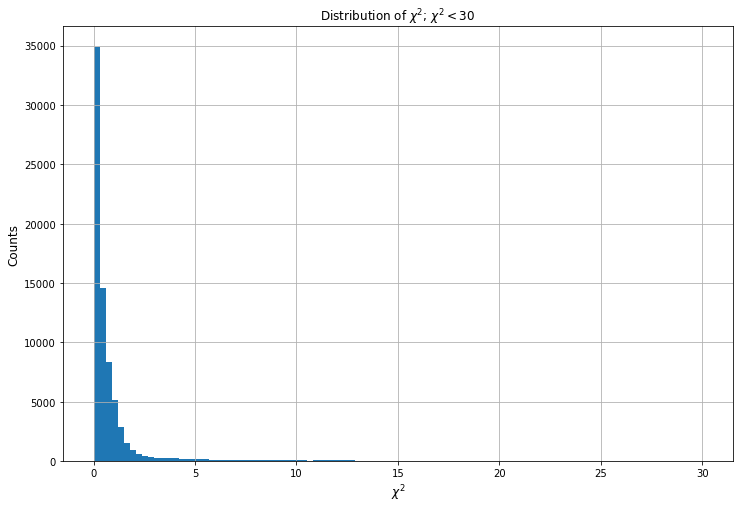

In [27]:
# plot chi^2 distribution
plt.figure(figsize = (12, 8))
plt.hist(result_local_df[result_local_df['reduced_chi2']<30]['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$; $\chi^2<30$', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

Plotting the 5 best and 5 worst fits (based on their reduced $\chi^2$ values):

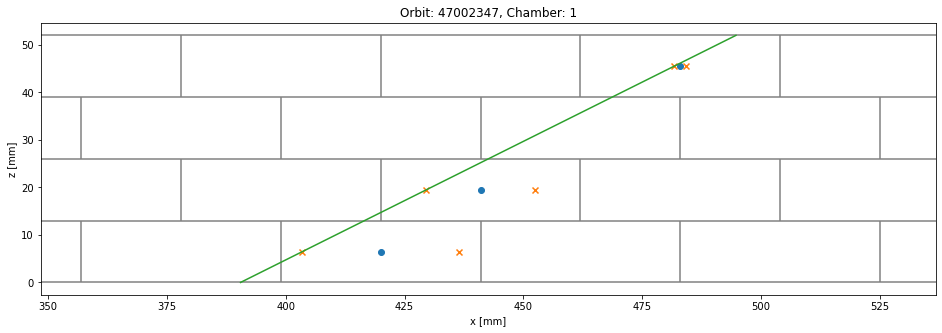

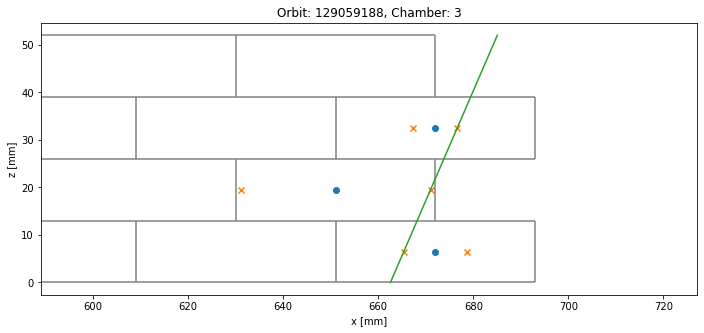

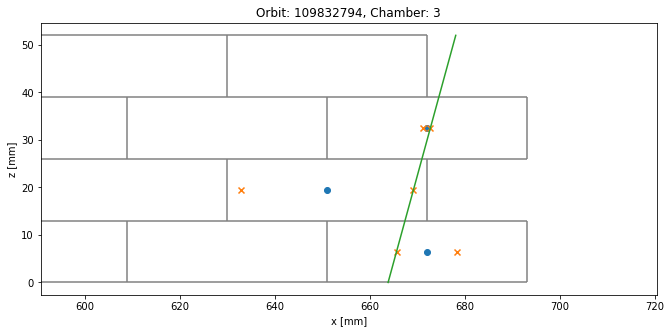

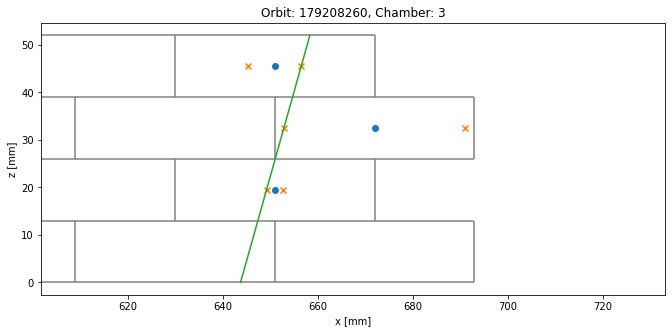

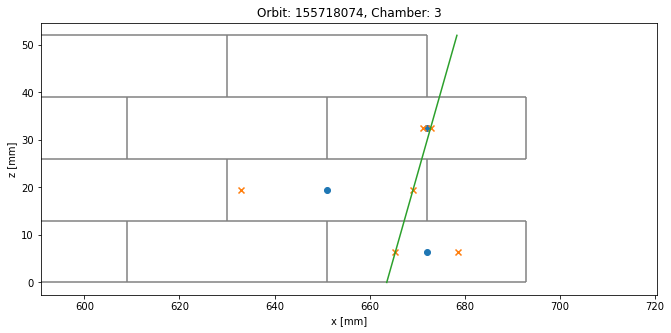

In [28]:
# plot the best chi^2:
best_idx = result_local_df.nsmallest(5, 'reduced_chi2').index
for idx in best_idx:
    plot_local_fit(result_local_df.loc[idx])

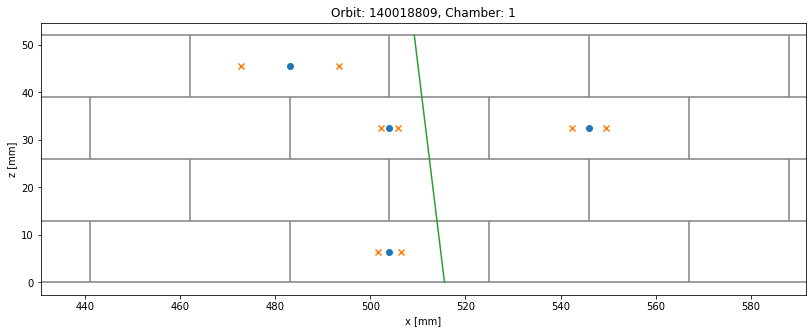

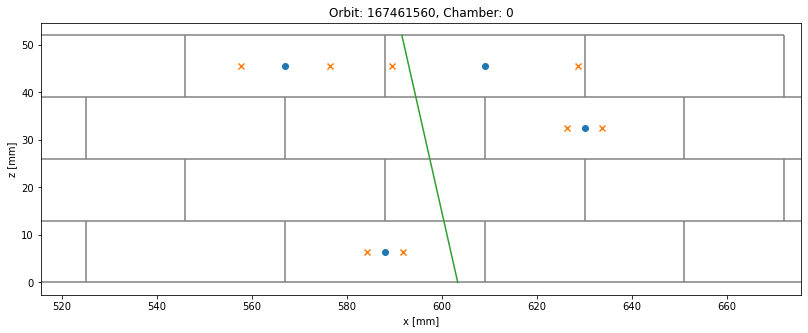

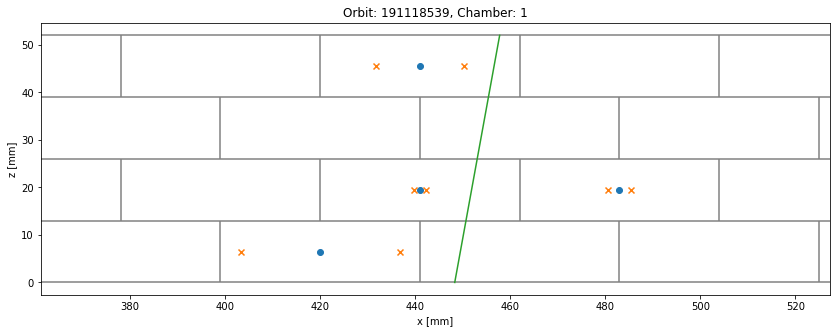

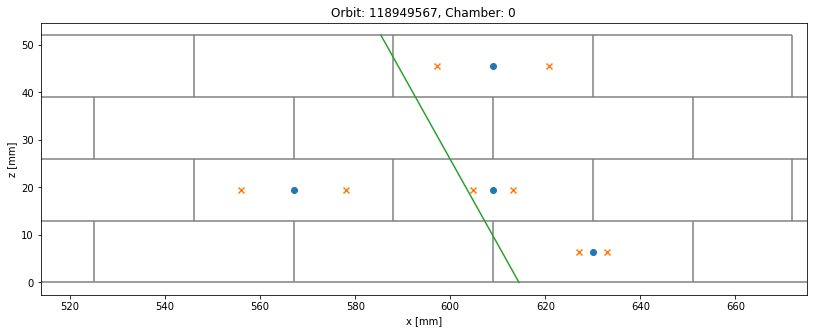

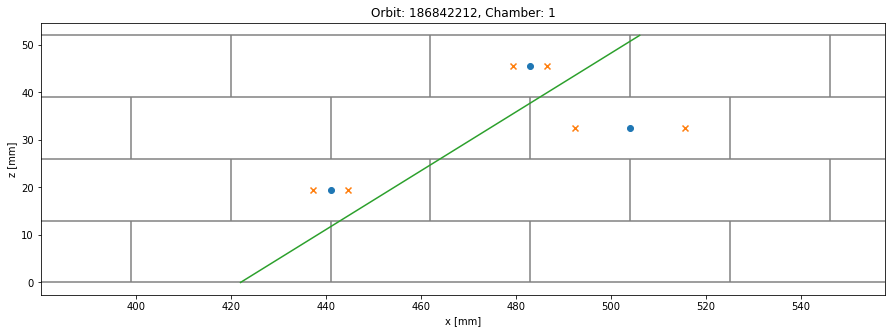

In [29]:
# plot the worst chi^2
worst_idx = result_local_df.nlargest(5, 'reduced_chi2').index
for idx in worst_idx:
    plot_local_fit(result_local_df.loc[idx]) 

In [30]:
# Save results into .parquet files
# result_local_df.to_parquet('/home/parisdiaz/local_tracks/local_tracks.parquet')

## Global Track Reconstruction
Now that we have gathered data for the local tracks, we try to apply the same methodology to the reconstruction of tracks throughout the whole set of detectors. At this point, we should mention that the hits of Chamber 1 have to be removed, as that chamber has a different spatial orientation (namely, it is rotated by 90˚ in the x-y plane). Otherwise, the procedure is somewhat similar to the one seen in the local tracks.

In [31]:
# Distances are assumed to be in mm
shift_chamber_z = {
    0: 219.8,
    1: 977.3,
    2: 1035.6,
    3: 1819.8
}

ddf_x_hit['z_global'] = ddf_x_hit['z_loc'] + ddf_x_hit['chamber'].map(shift_chamber_z)
df_GT_fresh = ddf_x_hit[ddf_x_hit['chamber'] != 1]

/home/parisdiaz/.local/lib/python3.10/site-packages/dask_expr/_collection.py:4190: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('chamber', 'float64'))

  warnings.warn(meta_warning(meta))


In [32]:
def fit_global(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fits global trajectories of cosmic rays (i.e., trajectories
    within all three interested detectors) with a similar
    approach as seen in the fit_local function. That is, we 
    are still using the least squares algorithm in a vectorized
    way.
    
    Args:
        df (pd.DataFrame): DataFrame containing the information
                           required to compute the global
                           trajectories.
                           
    Return:
        results (pd.DataFrame): DataFrame with information
                                about global trajectories
                                (hit coordinates, slope,
                                intercept, etc...)
        
    """
    
    # Get events with 3-12 hits from at least 4 different layer
    n_hits = len(df)  # get row count
    unique_chambers = len(np.unique(df['chamber']))
    if 3 <= n_hits <= 12 and unique_chambers >= 2 :

        # get x and z coordinates
        x_left = np.array(df['x_left_loc'].values)
        x_right = np.array(df['x_right_loc'].values)
        z = np.array(df['z_global'].values)

        # stack x coordinates
        stack = np.column_stack((x_left, x_right))
        # create array with all possible left/right combinations
        x = np.array(np.meshgrid(*stack)).reshape(df.shape[0] ,-1) 
        
        # prepare "coefficient" matrix for lstsq
        A = np.vstack((z, np.ones(np.shape(z)))).T
        
        # get fit coefficients & residuals from lstsq
        coeffs, residuals, _, _ = np.linalg.lstsq(A, x, rcond = None)
        
        # choose option with the lowest residual error
        choice = np.argmin(residuals)
        best_residuals = residuals[choice]
        slope = coeffs[0][choice]
        intercept = coeffs[1][choice]
        x_best = x.T[choice]
        red_chi2 = best_residuals / (df.shape[0] - 2)
        
        # save results to dataframe
        result = pd.DataFrame({
            'ORBIT': [df['ORBIT'].iloc[0]],
            'x_chamber_center': [df['x_chamber_center'].values],
            'x_left_loc': [x_left],
            'x_right_loc': [x_right],
            'x_best': [x_best],
            'z': [z],
            'slope': [slope],
            'intercept': [intercept],
            'reduced_chi2': [red_chi2]
        })
        
        return result
    
    else:
        # return empty dataframe
        return pd.DataFrame(columns = ['ORBIT',
                                       'x_chamber_center',
                                       'x_left_loc', 'x_right_loc',
                                       'x_best', 'z',
                                       'slope', 'intercept', 
                                       'reduced_chi2'])

In [33]:
meta = {
    'ORBIT': 'int32',
    'x_chamber_center': 'object',
    'x_left_loc': 'object',
    'x_right_loc': 'object',
    'x_best': 'object',
    'z': 'object',
    'slope': 'float32',
    'intercept': 'float32',
    'reduced_chi2': 'float32'}

groups_GT_fresh = df_GT_fresh.groupby('ORBIT').apply(fit_global,
                                                     meta=meta)
glob_results= groups_GT_fresh.compute()
glob_results.reset_index(drop = True, inplace = True)
glob_results.head(5)

,ORBIT,x_chamber_center,x_left_loc,x_right_loc,x_best,z,slope,intercept,reduced_chi2
0,1130581,"[504, 651, 483, 651, 504, 672, 483]","[503.7041, 650.1087142089843, 478.444933059692...","[504.2959, 651.8912857910157, 487.555066940307...","[503.7041, 651.8912857910157, 487.555066940307...","[1068.1, 1839.3, 1055.1, 1865.3, 1042.1, 1826....",0.205785,278.258246,53.245641
1,1273848,"[462, 441, 462, 483, 420, 420, 483, 441]","[459.3727652984619, 431.8593795074463, 452.244...","[464.6272347015381, 450.1406204925537, 471.755...","[464.6272347015381, 431.8593795074463, 471.755...","[1068.1, 1839.3, 1042.1, 1081.1, 1852.3, 1826....",-0.046760,517.816557,4.091249
2,1339572,"[504, 504, 462, 462, 483, 483, 483, 483]","[502.8971, 501.7762677612305, 454.697547268676...","[505.1029, 506.2237322387695, 469.302452731323...","[502.8971, 501.7762677612305, 469.302452731323...","[1042.1, 1068.1, 1852.3, 1826.3, 1865.3, 1081....",-0.041673,546.242714,0.139276
3,1378974,"[420, 126, 420, 399, 147, 126, 441, 147]","[418.94193305969236, 121.56687950744629, 415.4...","[421.05806694030764, 130.4331204925537, 424.59...","[418.94193305969236, 130.4331204925537, 424.59...","[1068.1, 1826.3, 1042.1, 1055.1, 1865.3, 1852....",-0.362024,804.838217,106.960266
4,1568953,"[483, 21, 42, 483, 462, 504]","[480.3727661193848, 11.330346447753906, 28.519...","[485.6272338806152, 30.669653552246096, 55.480...","[480.3727661193848, 30.669653552246096, 28.519...","[1055.1, 239.3, 226.3, 1081.1, 1042.1, 1068.1]",0.547569,-97.823293,4.511396


In [34]:
def plot_global_fit(df: pd.DataFrame):
    """
    Plot the tracks obtained through global fit
    """

    # plot including fit
    fig, ax = plt.subplots(figsize=(15, 30))

    # plot selected x values
    ax.scatter(df["x_best"], df["z"], marker='x', color='tab:orange')

    # draw the channel boundaries with hlines and vlines
    for i in [0, 2, 3]:
        z_shift= shift_chamber_z[i]
        # horizontal:
        ax.hlines(z_shift, xmin=21, xmax=693,  color='grey')
        ax.hlines(13*4+z_shift, xmin=0, xmax=672,  color='grey')

        for z in range(1, 4):
            ax.hlines(13*z+z_shift, xmin=0, xmax=693,  color='grey')

        # vertical:
        for x in range(17):
            ax.vlines(x=42*x, ymin=13+z_shift, ymax=26+z_shift, color="grey")
            ax.vlines(x=42*x, ymin=39+z_shift, ymax=52+z_shift, color="grey")
            ax.vlines(x=21+42*x, ymin=z_shift, ymax=13+z_shift, color="grey")
            ax.vlines(x=21+42*x, ymin=26+z_shift, ymax=39+z_shift, color="grey")

    # plot linear fit result
    z_fit = np.arange(150, 1900) # generate z values
    x_fit = df["slope"]*z_fit + df["intercept"] # calculate x values from fit params
    ax.plot(x_fit, z_fit, color="tab:green")


    # set labels etc
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"Orbit: {int(df['ORBIT'])}")
    
    plt.show()

In [35]:
glob_results["reduced_chi2"].describe()

count    22288.000000
mean       376.069636
std       2499.430664
min          0.000131
25%          0.280114
50%          1.092549
75%         12.769995
max      65320.242909
Name: reduced_chi2, dtype: float64

In [36]:
glob_results[glob_results["reduced_chi2"]>30].describe()

,slope,intercept,reduced_chi2
count,3484.000000,3484.000000,3484.000000
mean,0.046353,411.721838,2385.124952
std,0.215016,224.120662,5931.989837
min,-0.613077,-675.558702,30.004997
25%,-0.099040,255.956730,48.359329
50%,0.052046,408.382072,161.458675
75%,0.196520,568.844693,1706.718083
max,0.733711,1212.419392,65320.242909


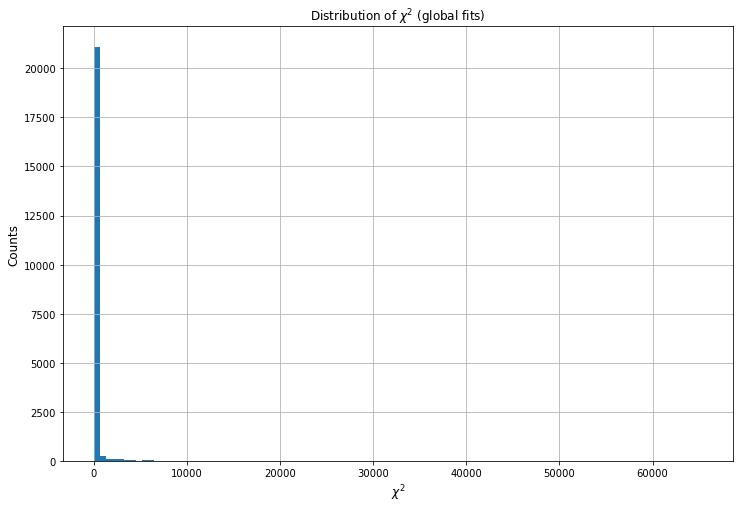

In [37]:
# Plot the chi2 distribution
plt.figure(figsize = (12, 8))
plt.hist(glob_results['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$ (global fits)', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

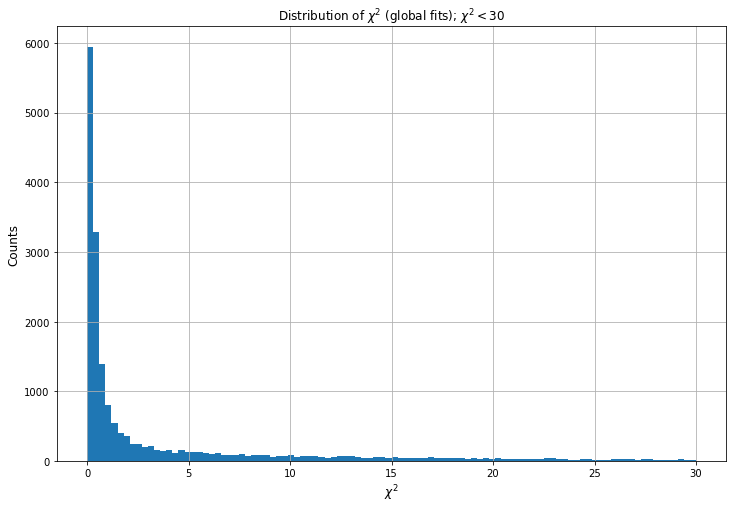

In [38]:
# Plot the chi2 distribution for chi2 < 30
plt.figure(figsize = (12, 8))
plt.hist(glob_results[glob_results['reduced_chi2']<30]['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$ (global fits); $\chi^2<30$', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

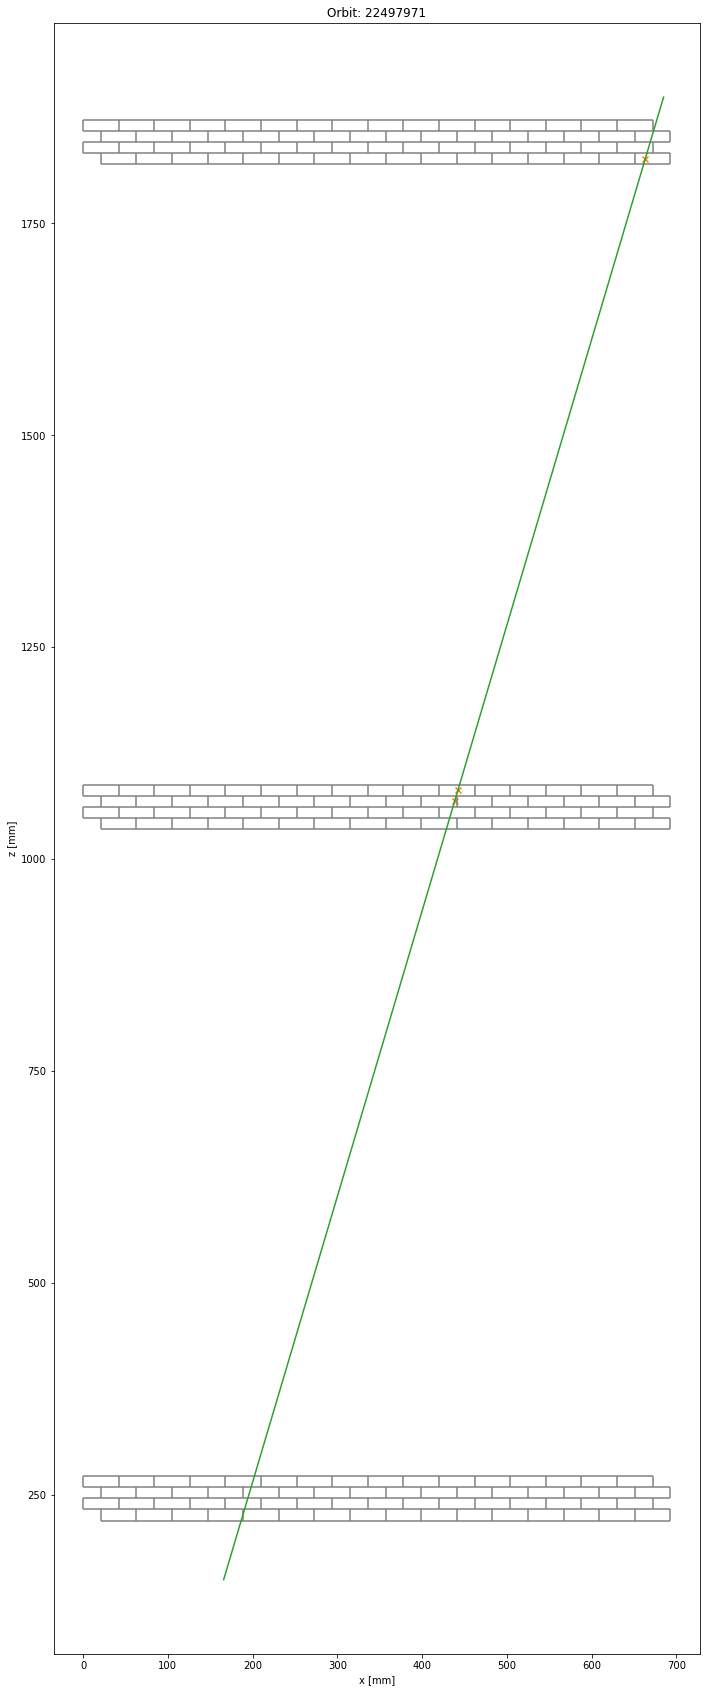

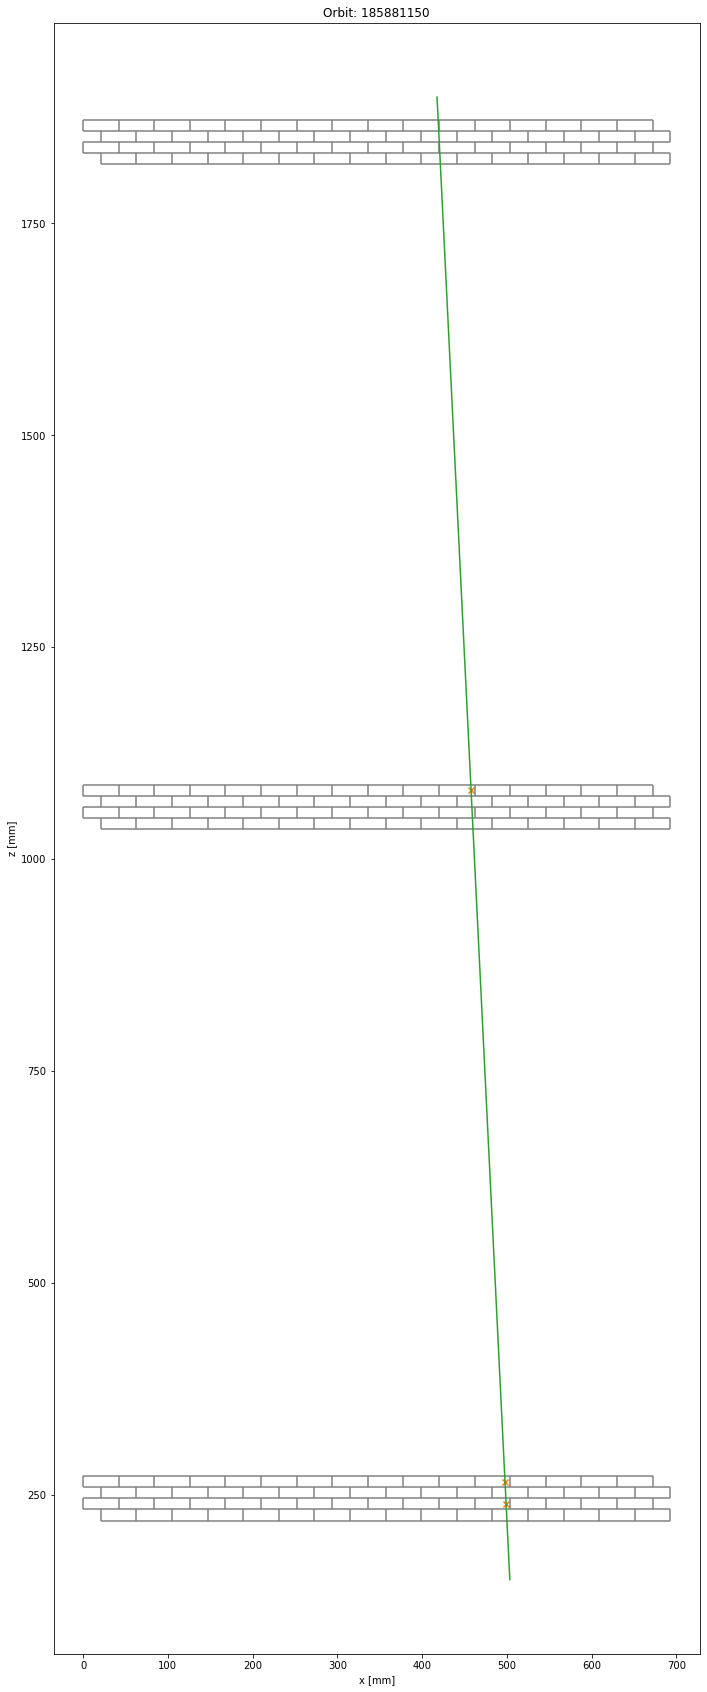

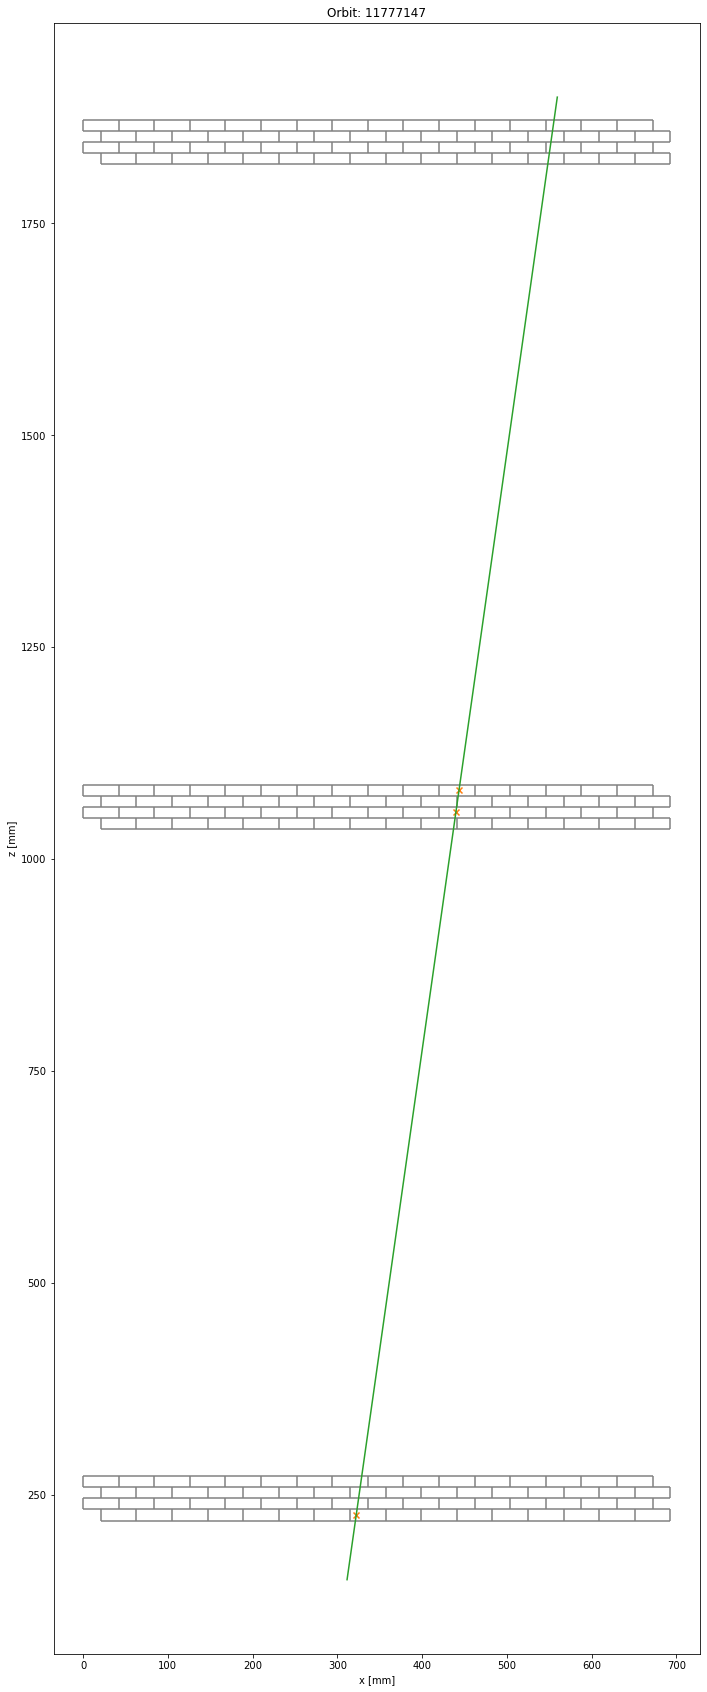

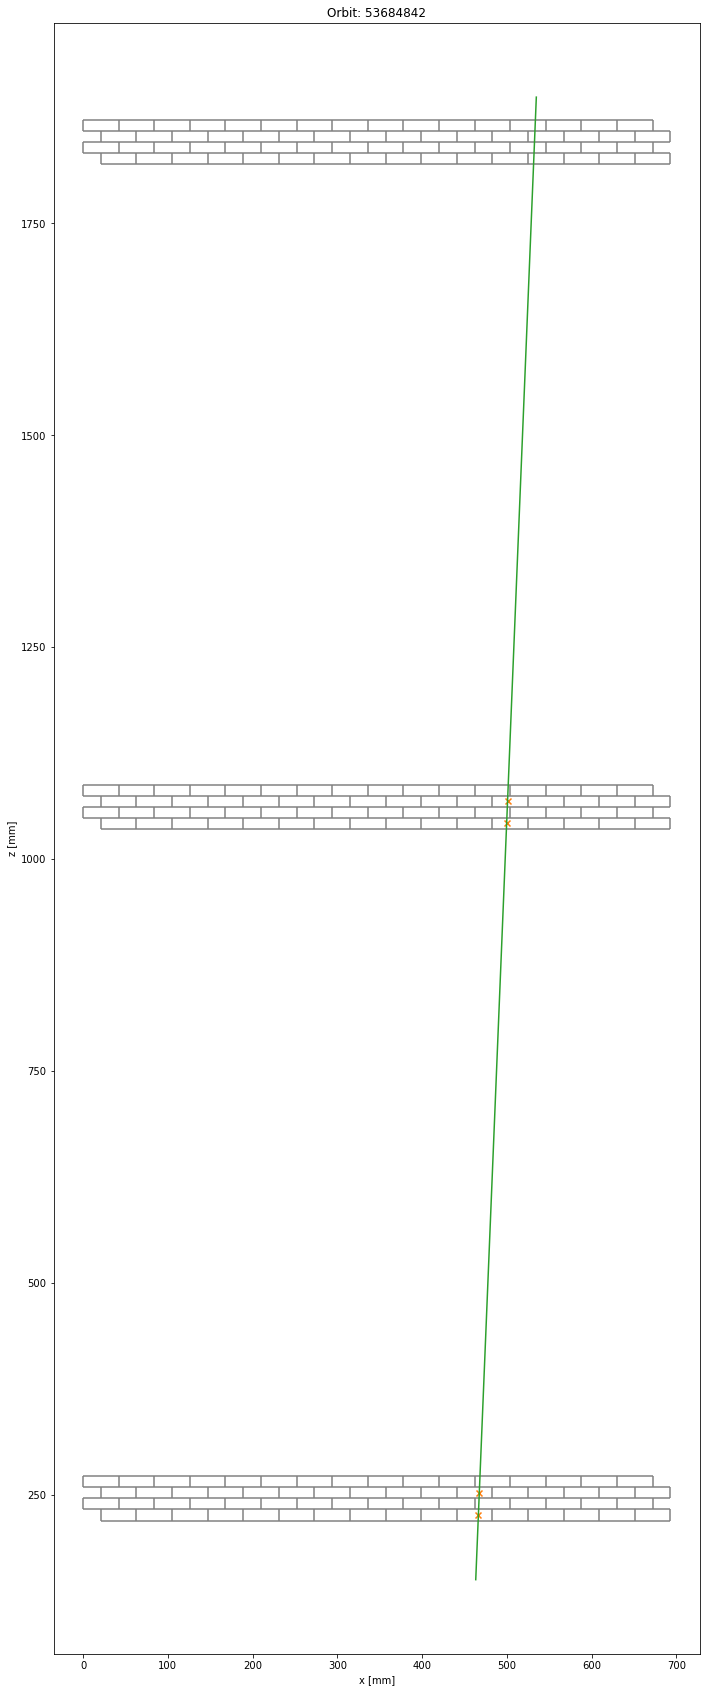

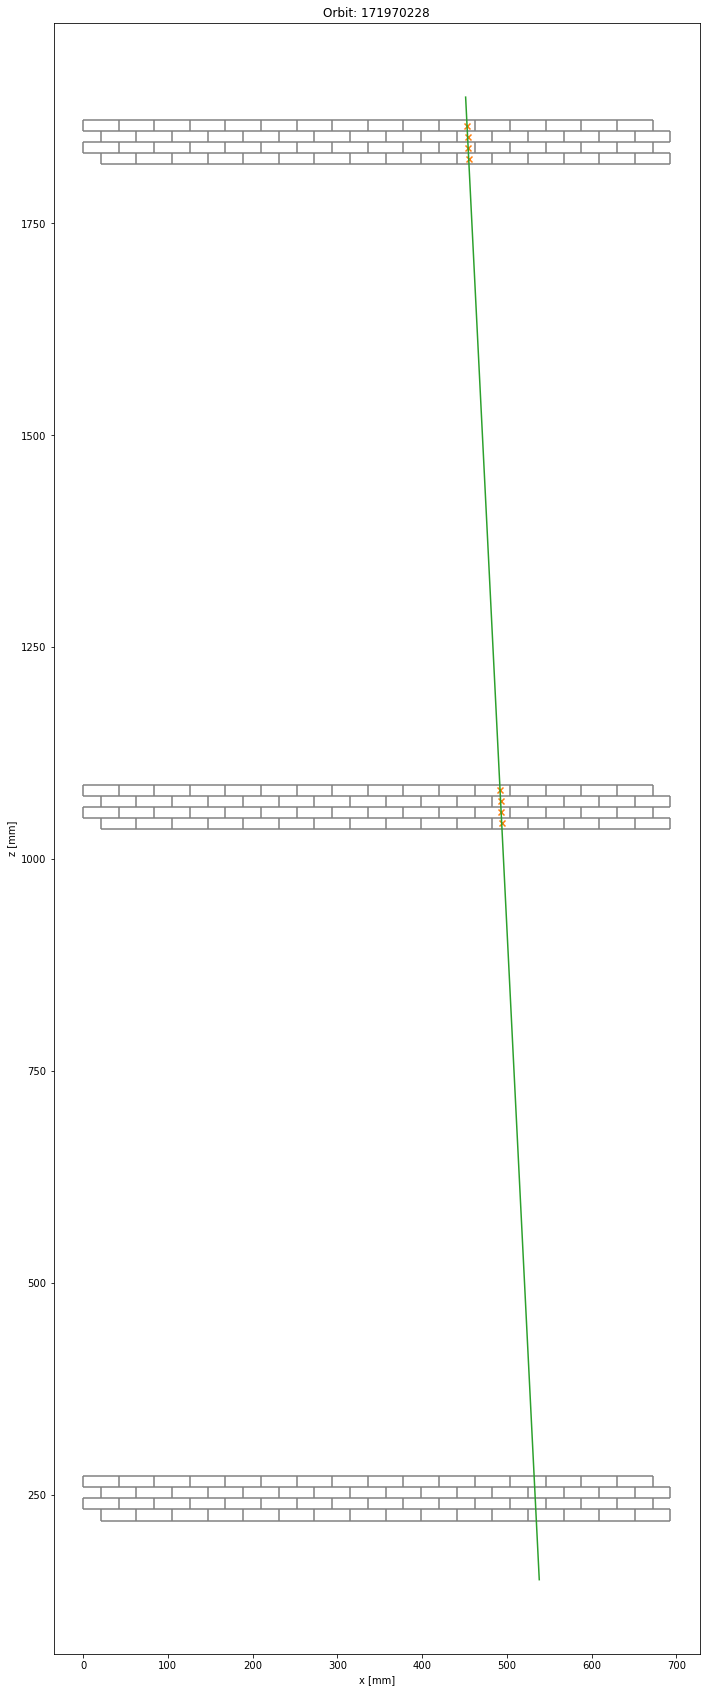

In [39]:
# Plot the ones with the best chi2
best_idx = glob_results.nsmallest(5, 'reduced_chi2').index
for idx in best_idx:
    plot_global_fit(glob_results.loc[idx])

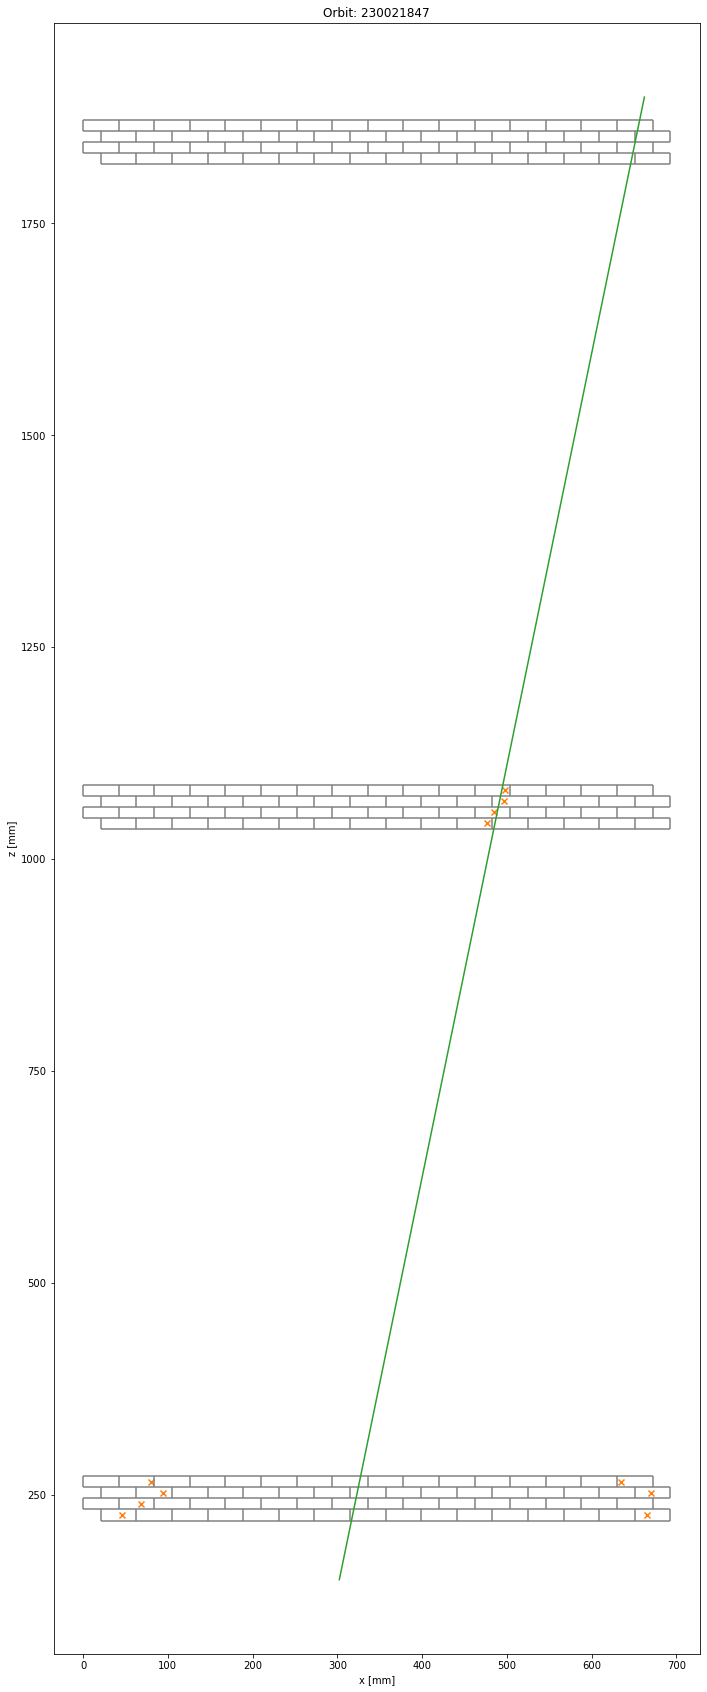

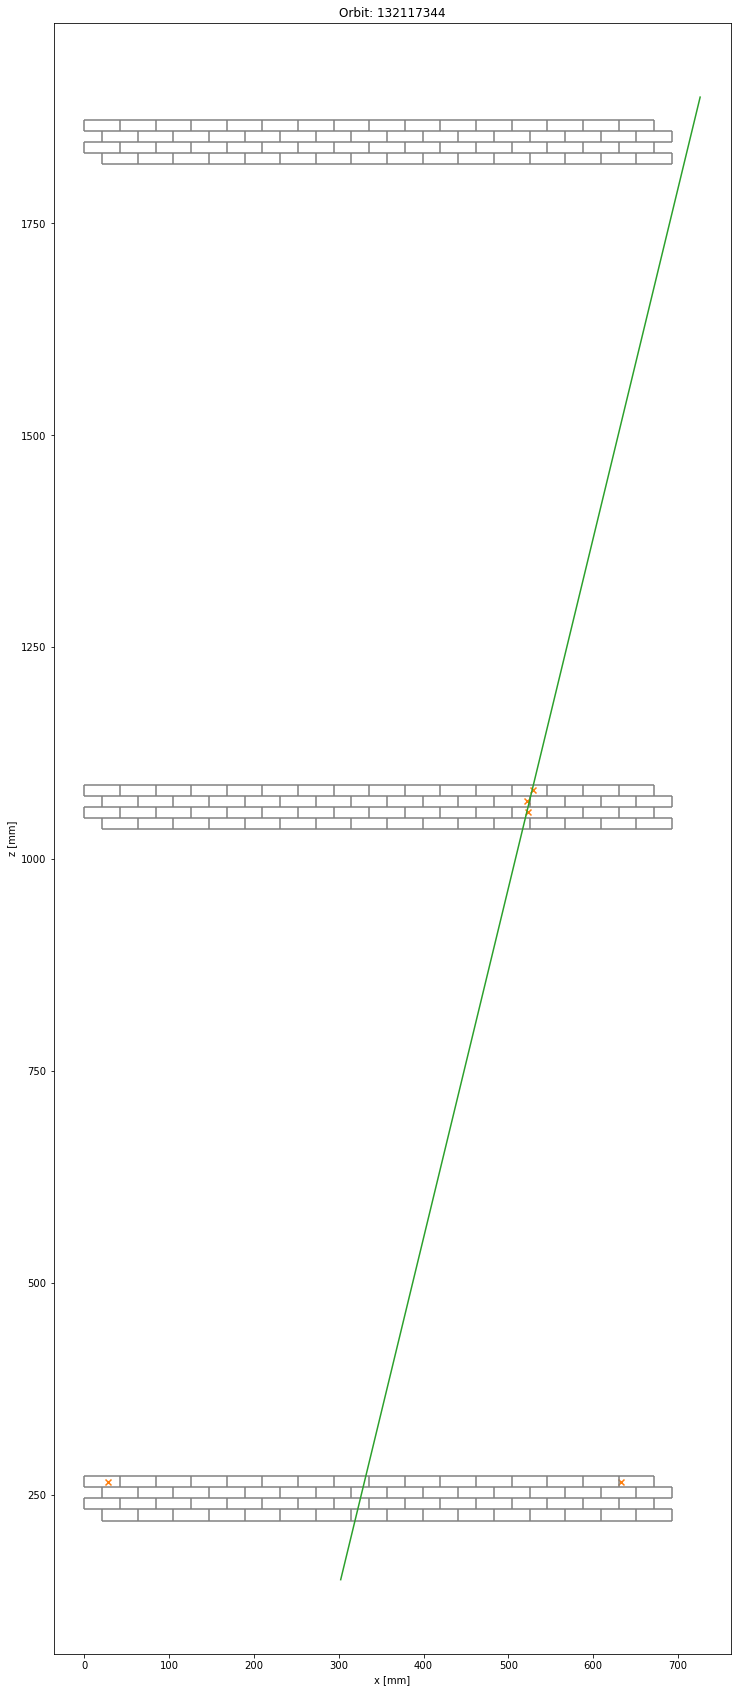

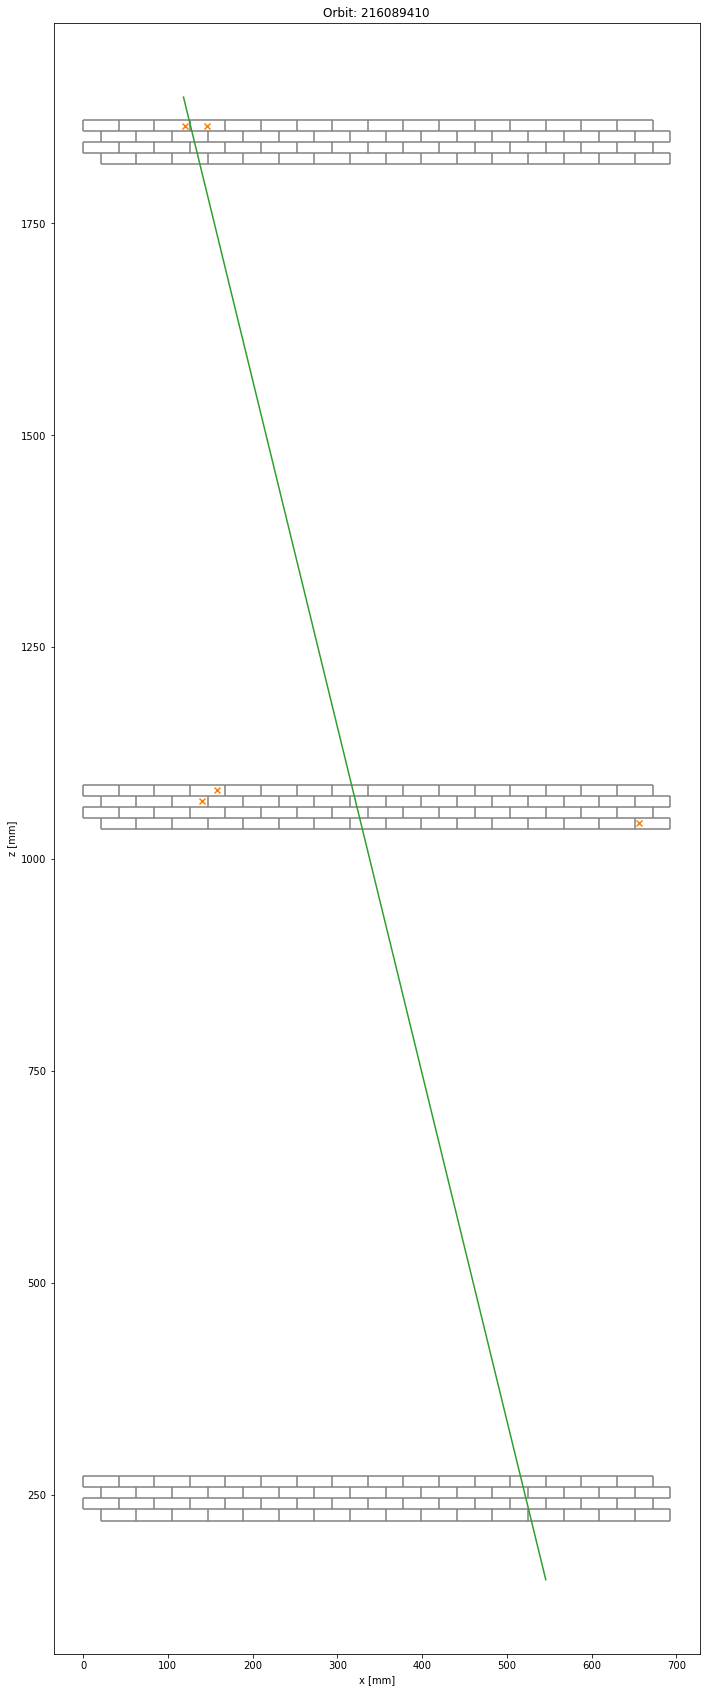

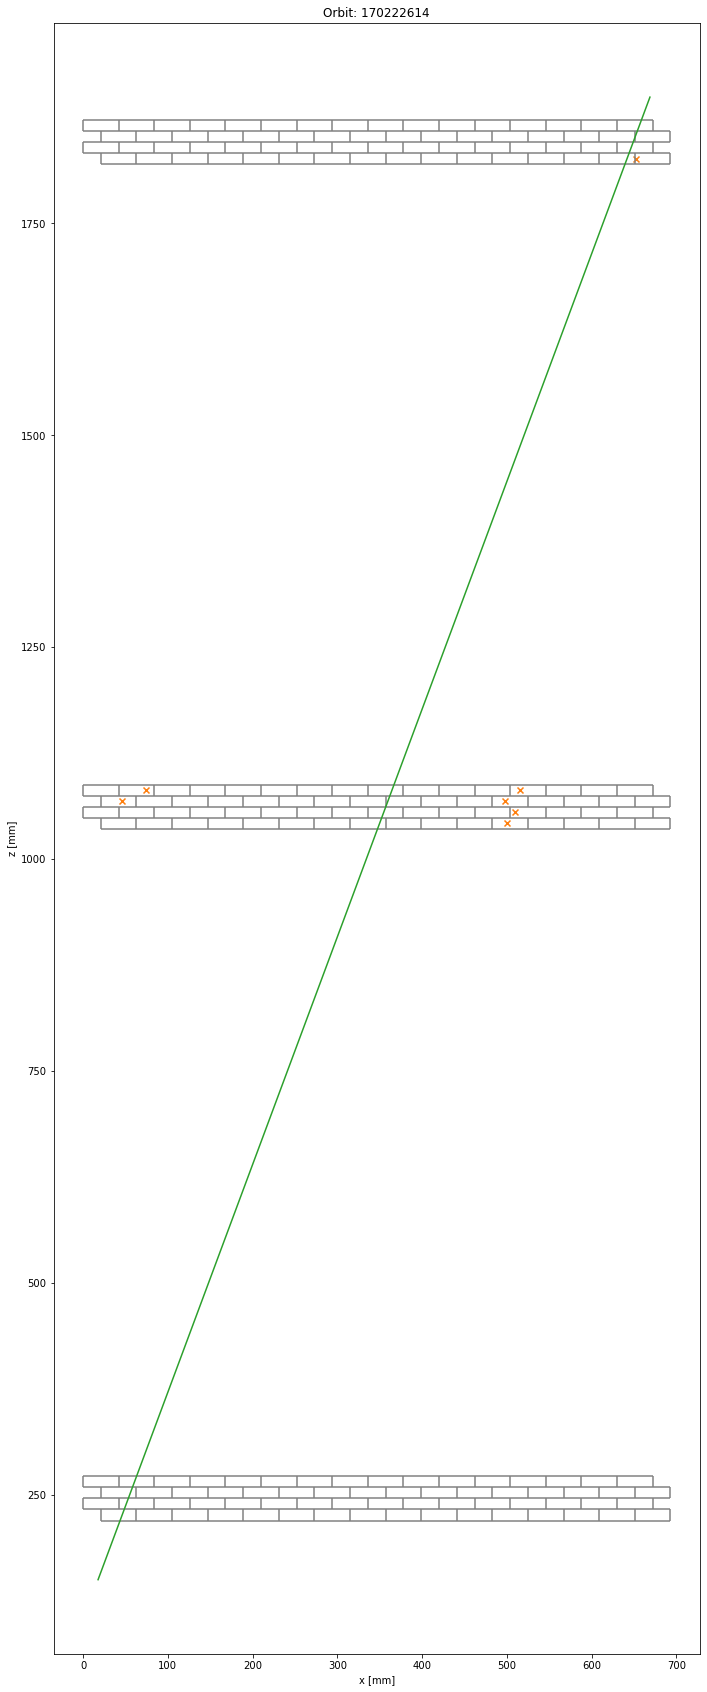

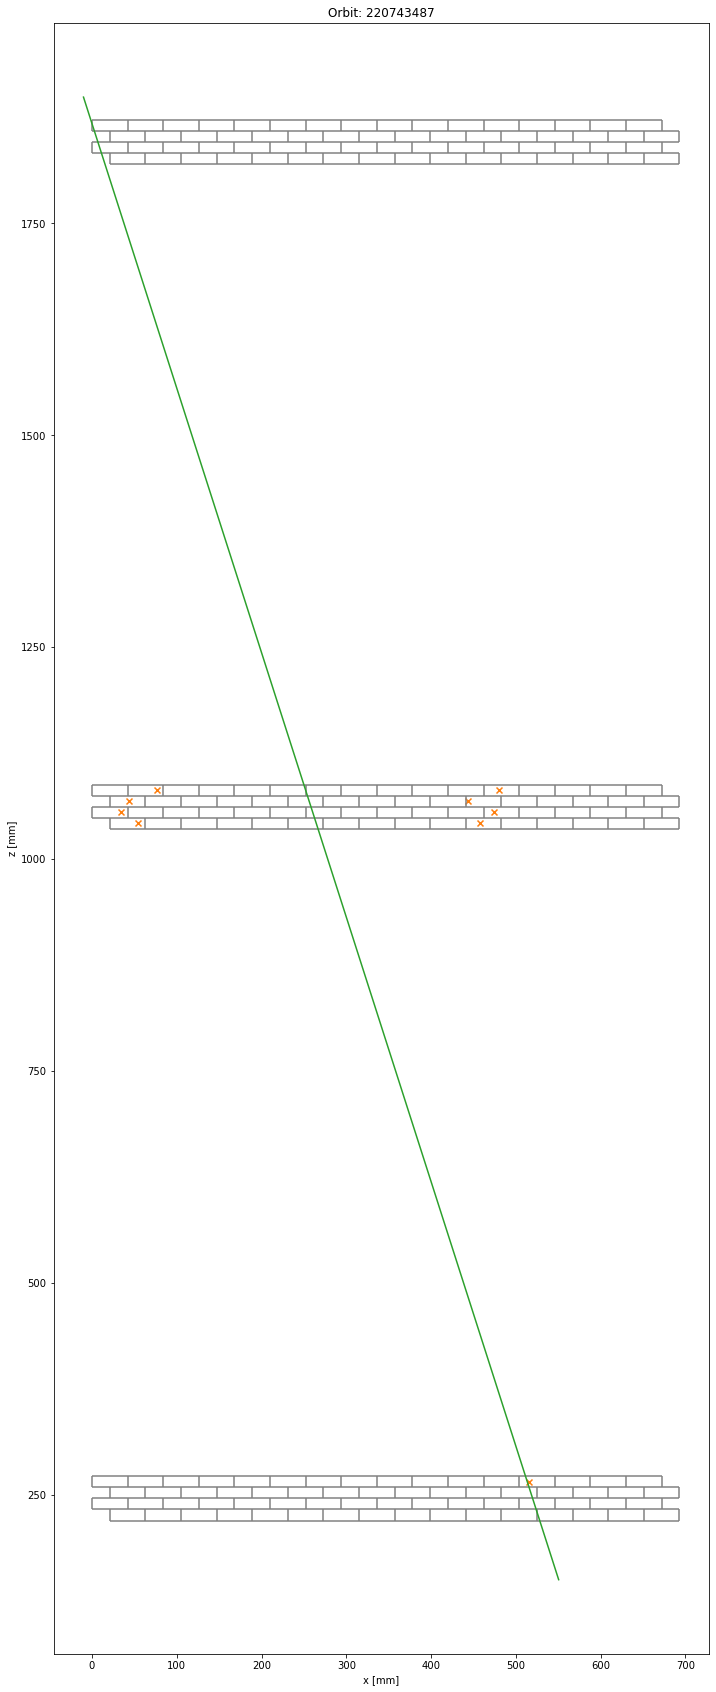

In [40]:
# Plot the ones with the worst chi2
worst_idx = glob_results.nlargest(5, 'reduced_chi2').index
for idx in worst_idx:
    plot_global_fit(glob_results.loc[idx]) 

## Side-Test: Global Fit on Preselected Events
As an additional test, we try to see what happens if, instead of fitting the tracks from scratch, we fit on the hits identified via the local fit. <br>
An important aspect that should be noted about this test is that it is **NOT** carried out with Dask and is merely performed to explore a few more options. The reason why we do not use Dask for this part of the analysis is that we had many issues with the `.groupby()` method in Dask and, apparently, with the way it interacts with the `meta` argument of `.apply()`. Upon inspection with the Dask community, we realize that we might have to open an issue with the maintainers of Dask itself.

In [41]:
def fit_global_preselected(df):
    x_points = np.concatenate(df['x_best'].values)
    z_points = np.concatenate(df['z_global'].values)
    unique_chambers = len(np.unique(df['chamber']))
    
    if unique_chambers >= 2:
        if len(x_points) > 0 and len(z_points) > 0 and np.isfinite(x_points).all() and np.isfinite(z_points).all():
            A = np.vstack([z_points, np.ones(len(z_points))]).T

            coeffs, residuals, _, _ = np.linalg.lstsq(A, x_points, rcond = None)

            slope = coeffs[0]
            intercept = coeffs[1]
            red_chi2 = residuals / (len(x_points) - 2 + 1e-10)

            result = pd.DataFrame({
                'ORBIT': [df['ORBIT'].iloc[0]],
                'x_chamber_center': [df['x_chamber_center'].values],
                'x_left_loc': [df['x_left_loc'].values],
                'x_right_loc': [df['x_right_loc'].values],
                'x_best': [x_points],
                'z': [z_points],
                'slope': [slope],
                'intercept': [intercept],
                'reduced_chi2': red_chi2
            })

            return result
        else:
            return pd.DataFrame()

In [42]:
result_local_df['z_global'] = result_local_df['z_loc'] + result_local_df['chamber'].map(shift_chamber_z)
df_GT = result_local_df[result_local_df['chamber'] != 1]

In [43]:
groups_GT = df_GT.groupby('ORBIT').apply(fit_global_preselected)
groups_GT.reset_index(drop = True, inplace = True)

/tmp/ipykernel_311178/1405501129.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups_GT = df_GT.groupby('ORBIT').apply(fit_global_preselected)


In [44]:
groups_GT['reduced_chi2'].describe()

count    19175.000000
mean        41.967303
std        469.407220
min          0.001603
25%          0.237902
50%          0.652635
75%          4.816169
max      24054.991206
Name: reduced_chi2, dtype: float64

In [45]:
groups_GT[groups_GT['reduced_chi2']>30].describe()

,ORBIT,slope,intercept,reduced_chi2
count,1.872000e+03,1872.000000,1872.000000,1872.000000
mean,1.155198e+08,0.033556,425.298439,403.122636
std,6.760972e+07,0.184822,193.192737,1453.675856
min,1.130581e+06,-0.592971,-113.037144,30.004997
25%,5.526381e+07,-0.098826,299.826129,43.576325
50%,1.145864e+08,0.039024,416.244409,77.985476
75%,1.723510e+08,0.151230,568.964315,206.906990
max,2.458596e+08,0.625504,1161.254252,24054.991206


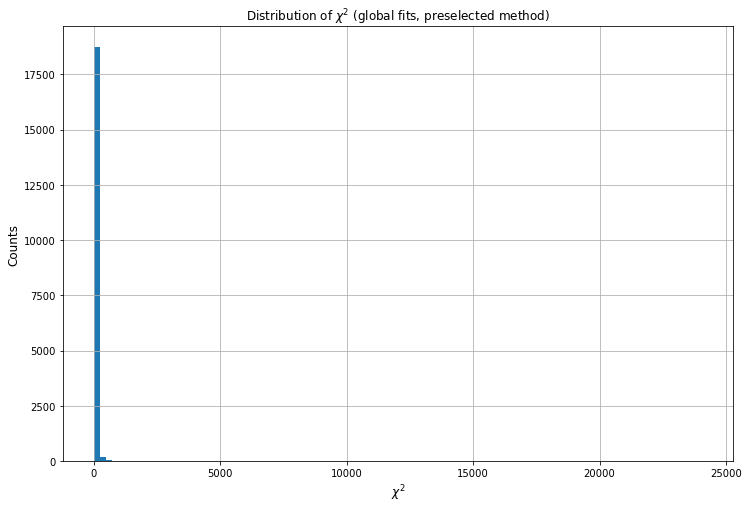

In [46]:
# plot chi^2 distribution
plt.figure(figsize = (12, 8))
plt.hist(groups_GT['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$ (global fits, preselected method)', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

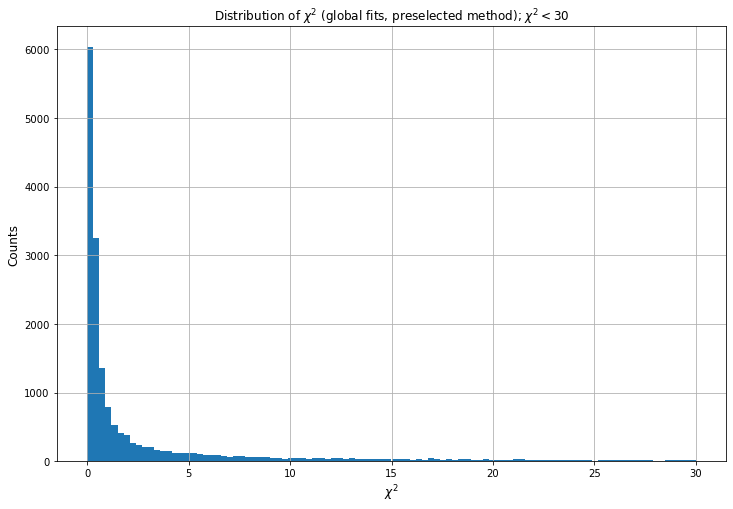

In [47]:
# plot chi^2 distribution for chi2<30
plt.figure(figsize = (12, 8))
plt.hist(groups_GT[groups_GT['reduced_chi2']<30]['reduced_chi2'], bins=100)
plt.title('Distribution of $\chi^2$ (global fits, preselected method); $\chi^2<30$', fontsize = 'large')
plt.xlabel('$\chi^2$', fontsize = 'large')
plt.ylabel('Counts', fontsize = 'large')
plt.grid(True)

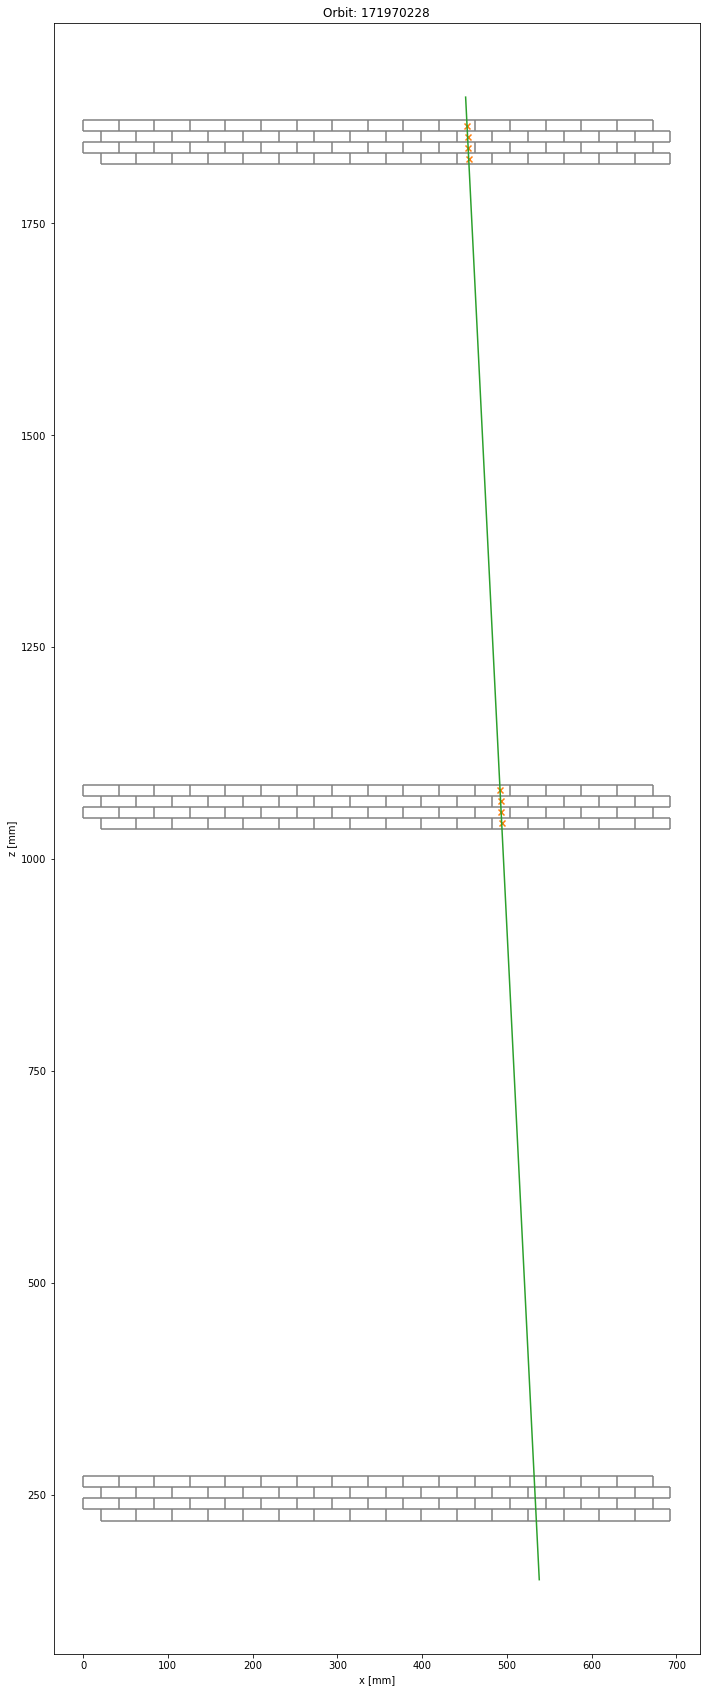

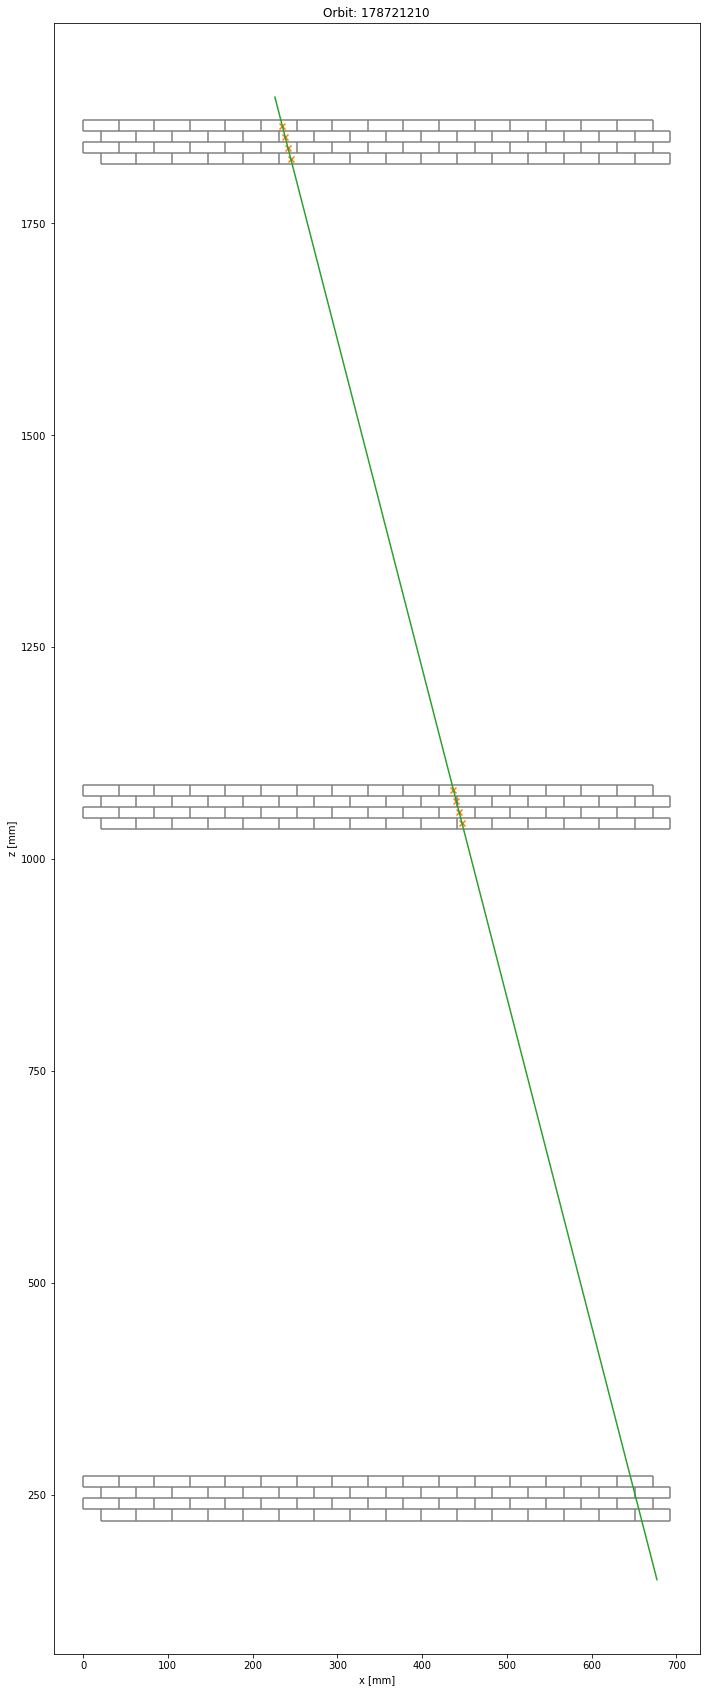

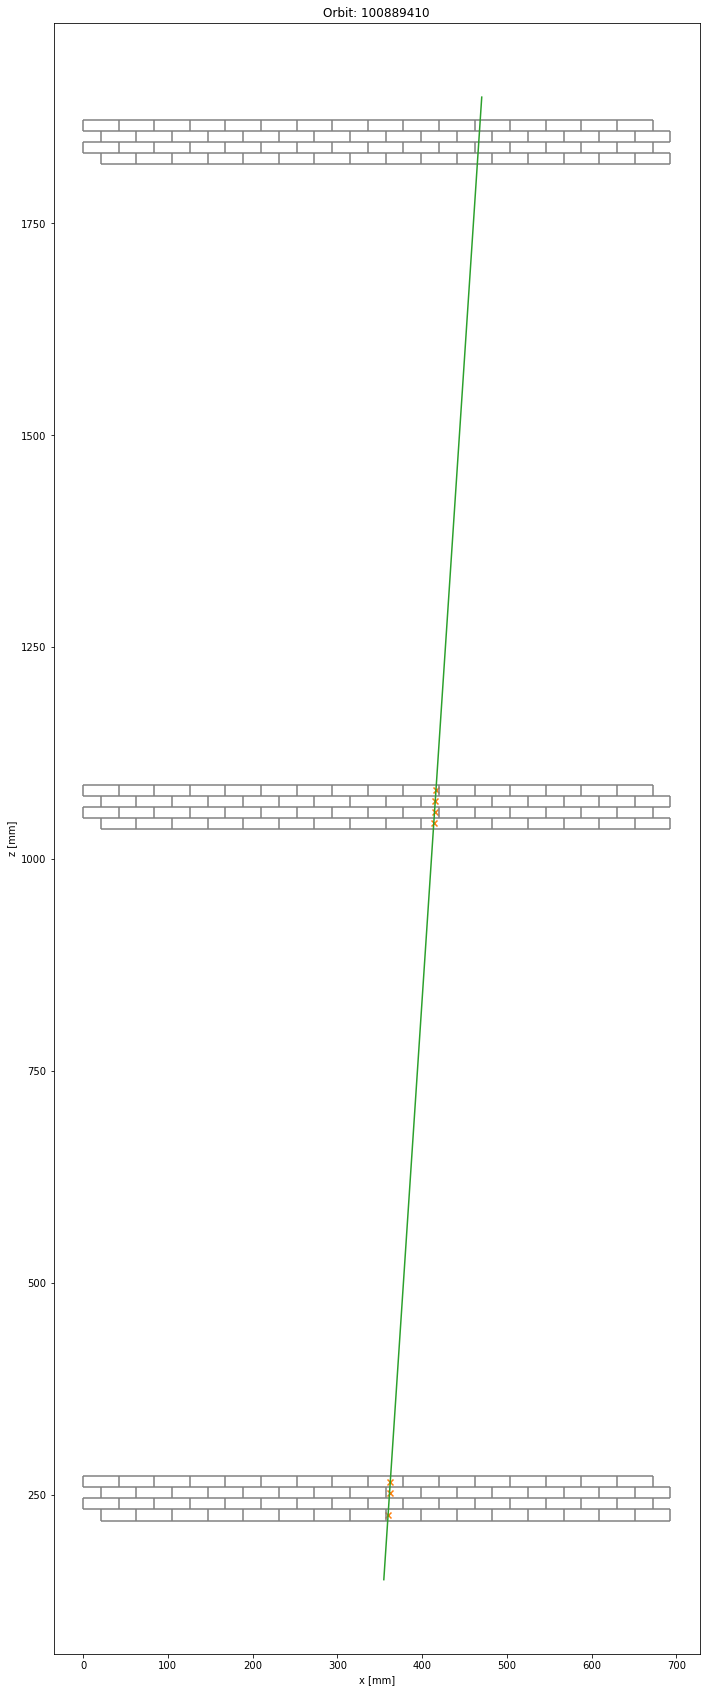

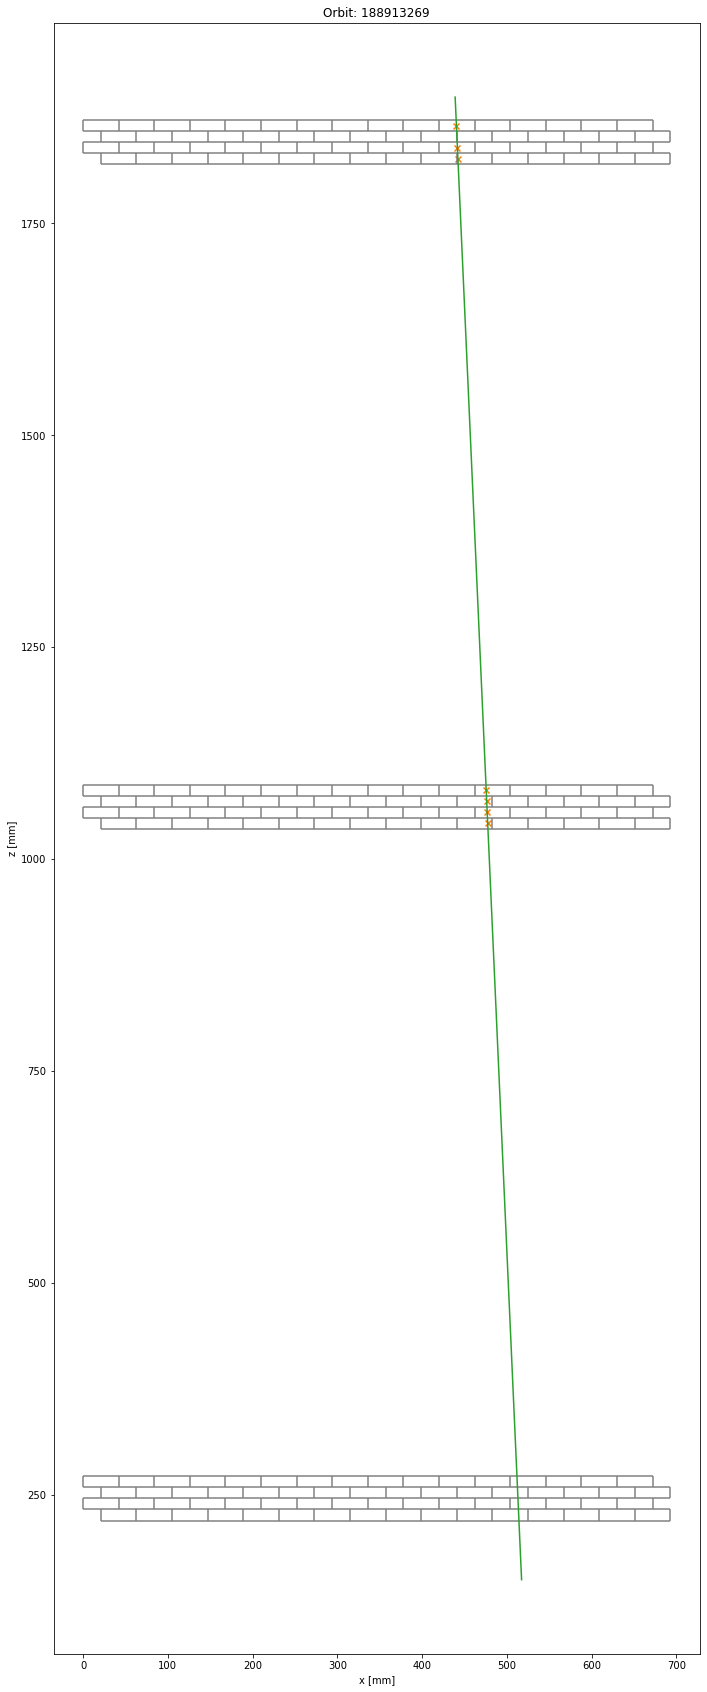

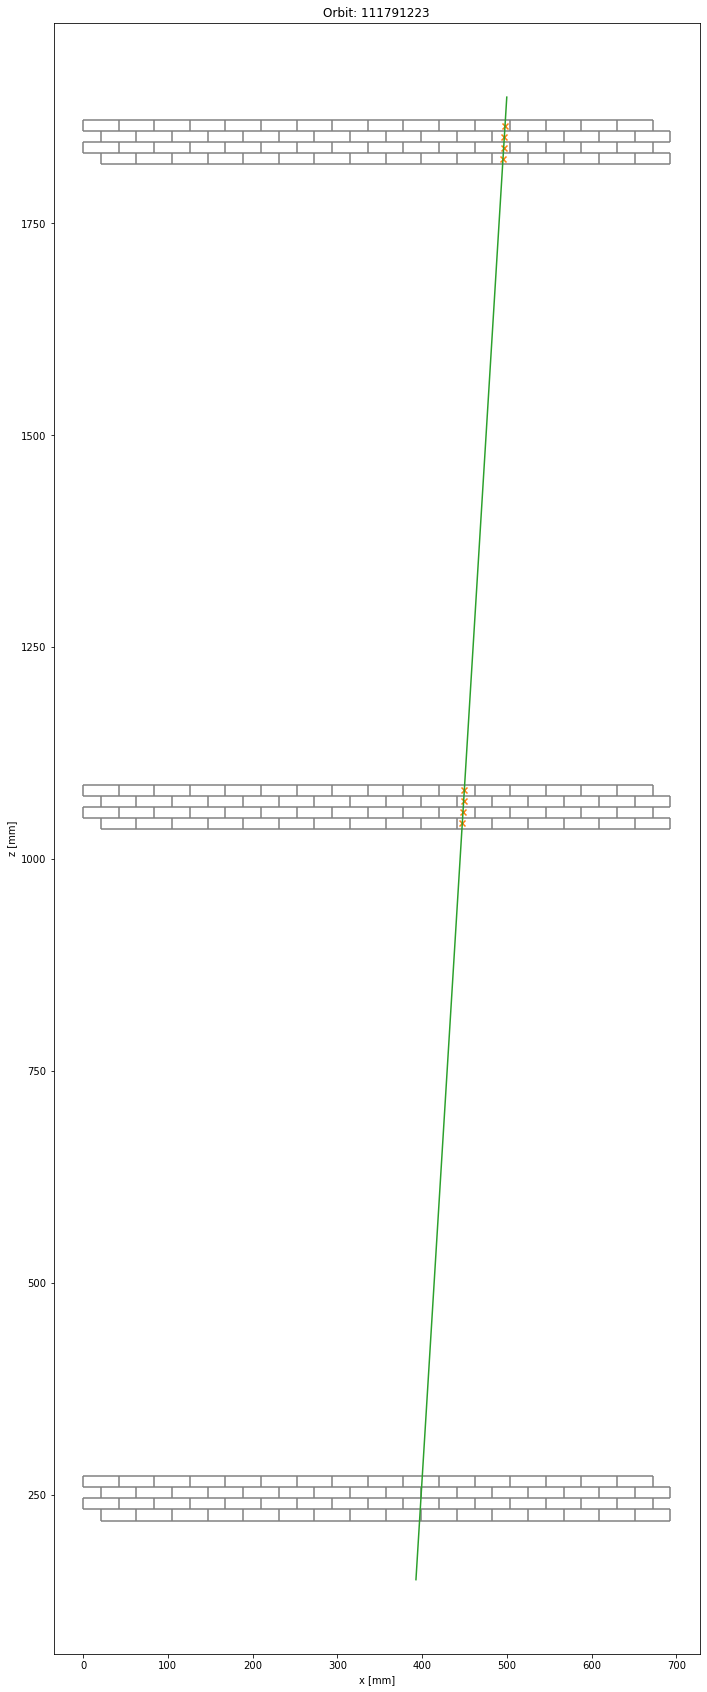

In [48]:
# Plot the 5 best fits:
best_idx = groups_GT.nsmallest(5, 'reduced_chi2').index
for idx in best_idx:
    plot_global_fit(groups_GT.loc[idx])

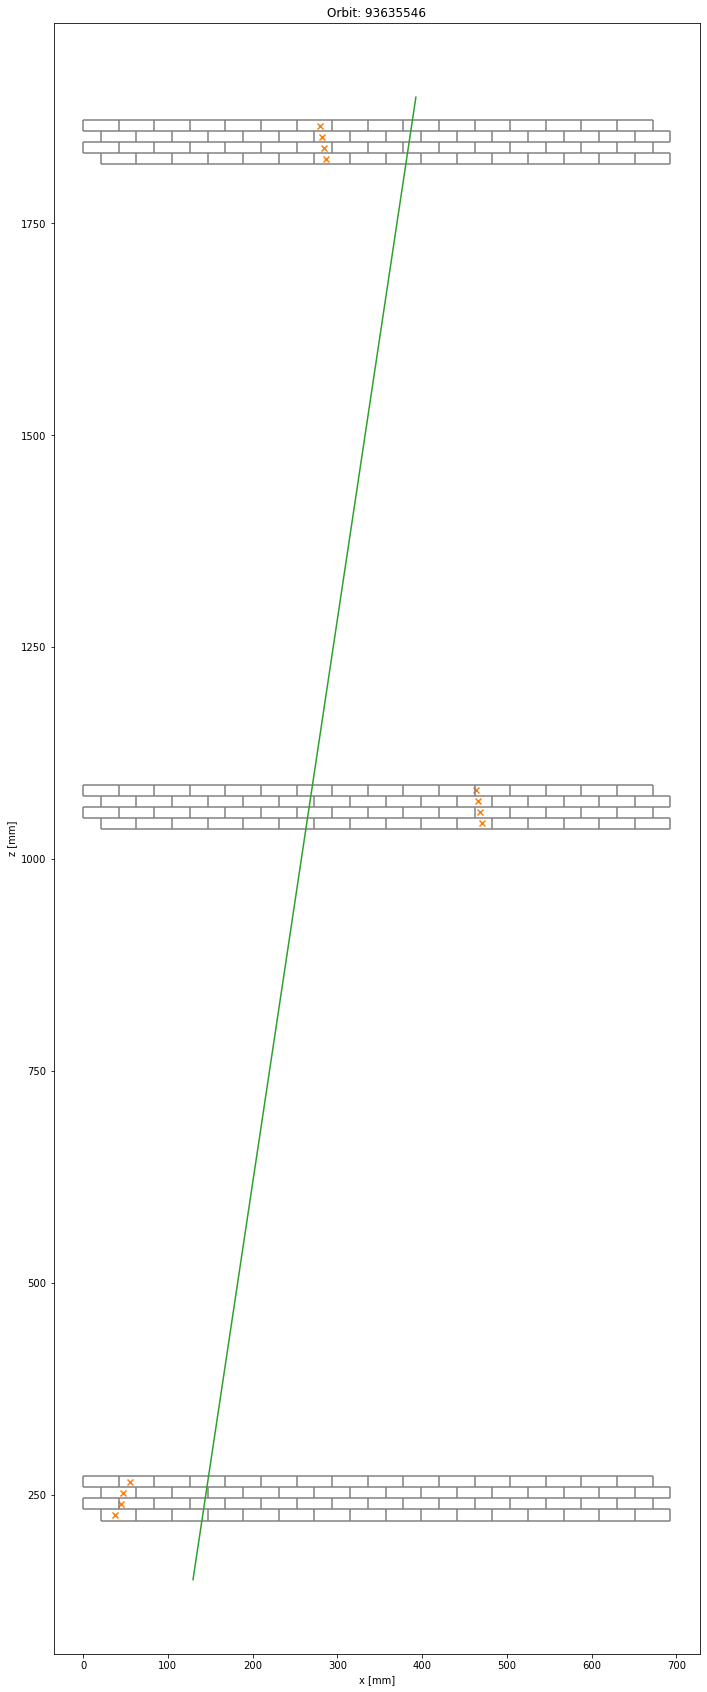

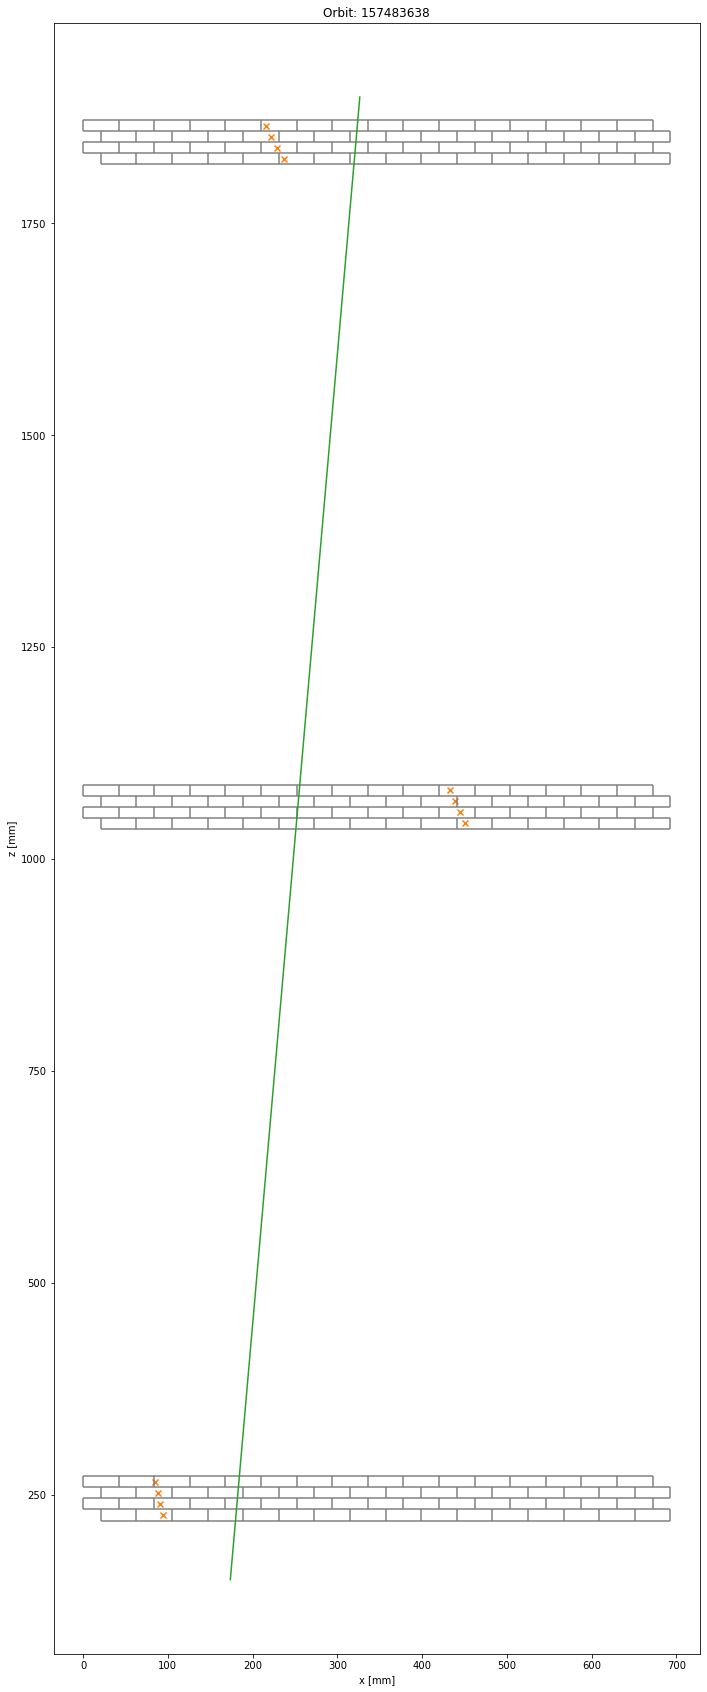

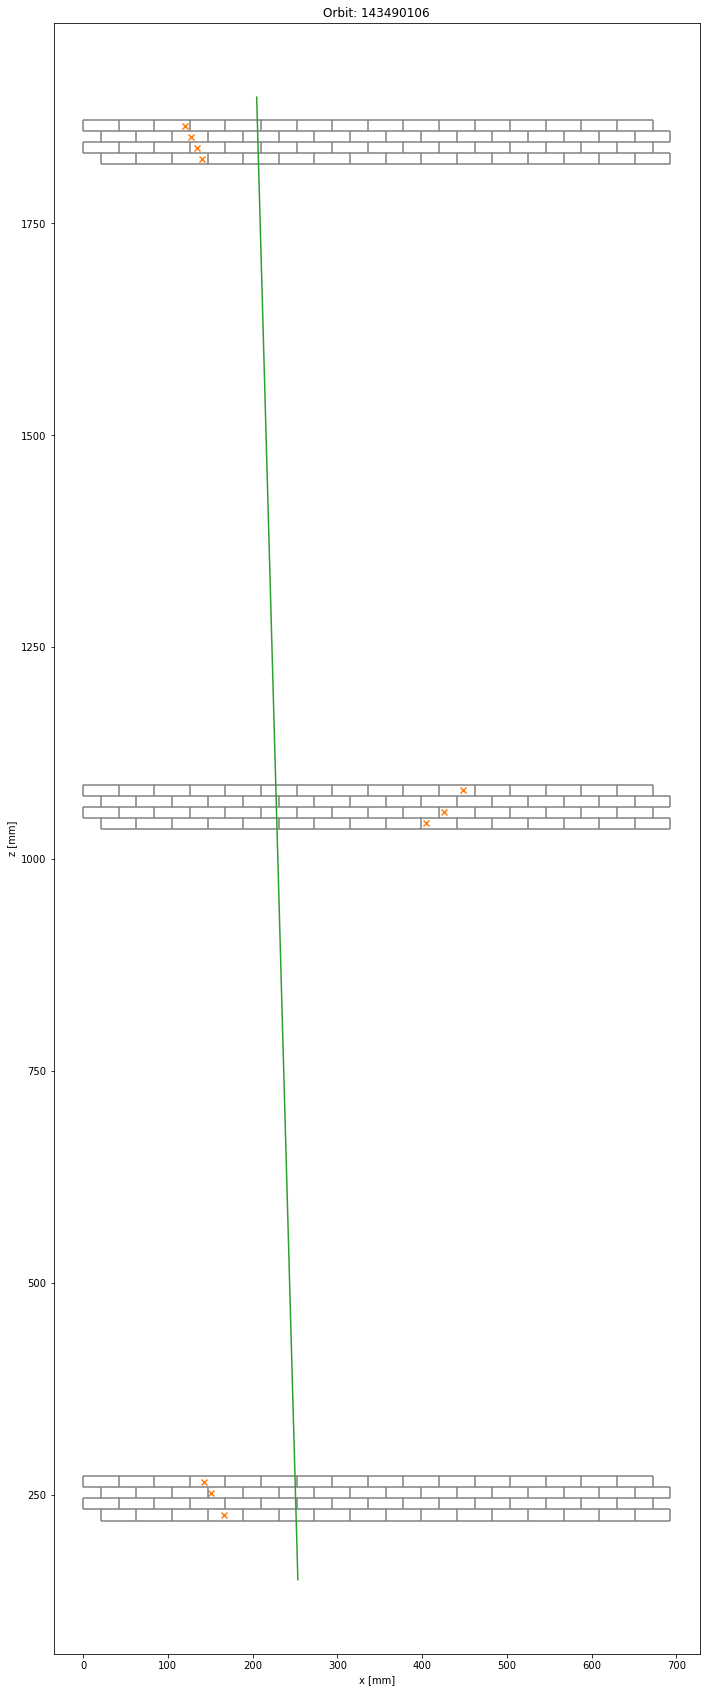

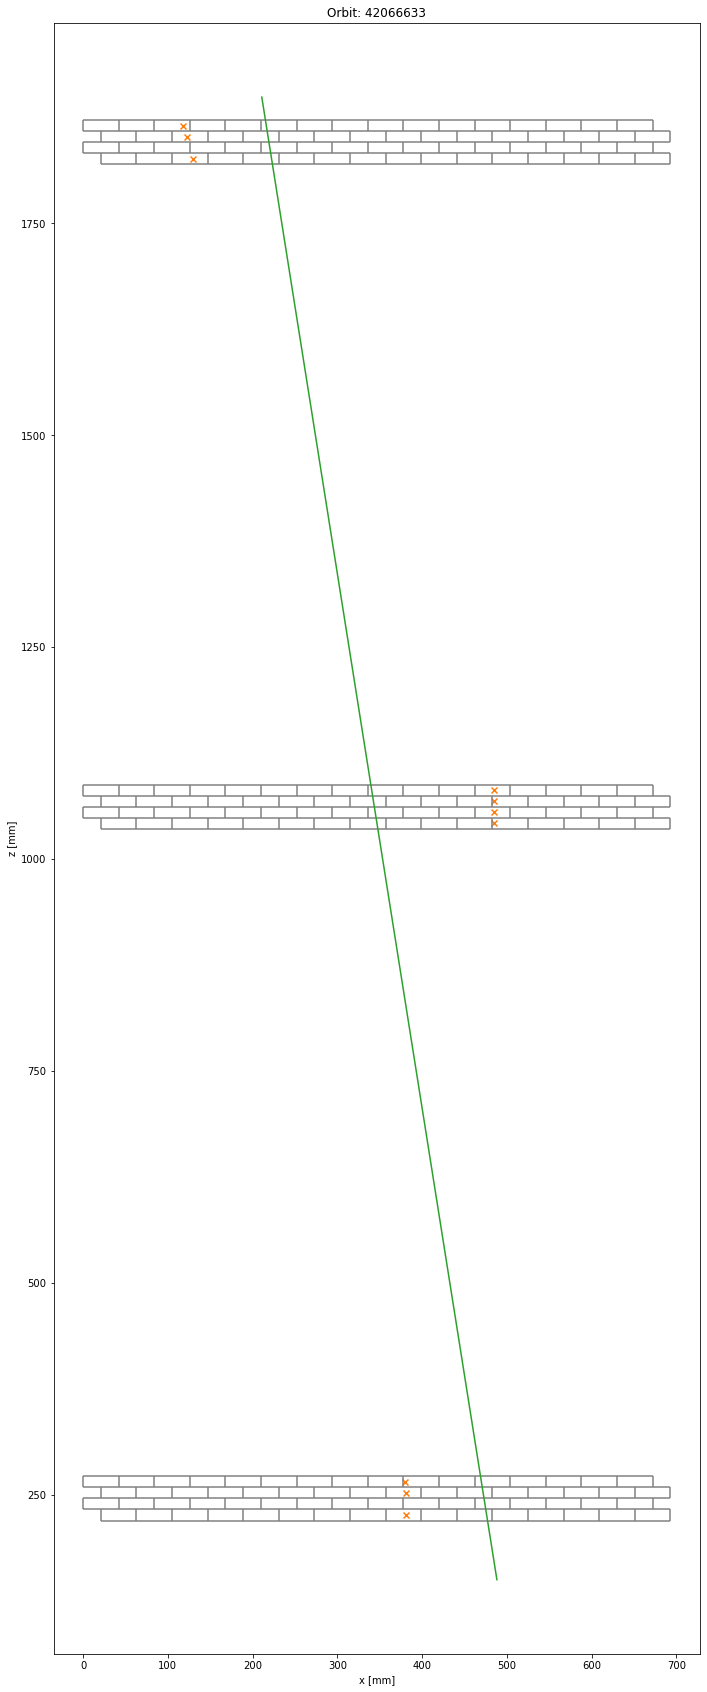

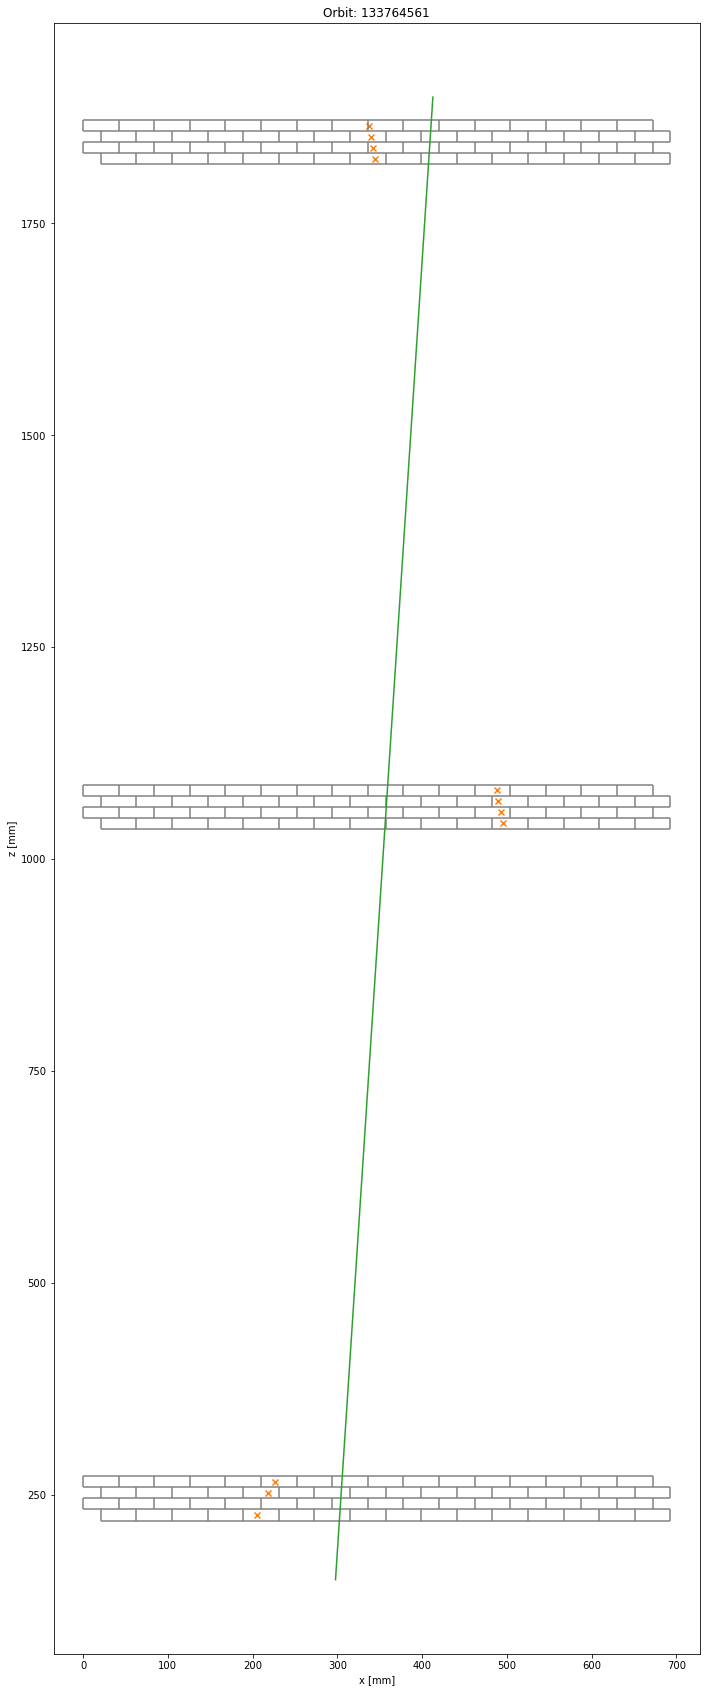

In [49]:
# Plot the 5 worst fits:
worst_idx = groups_GT.nlargest(5, 'reduced_chi2').index
for idx in worst_idx:
    plot_global_fit(groups_GT.loc[idx])

## Detector Angular Resolution
The final task of this project is the analysis of the difference between the angle (in milli-radians) of the global track and the local track measured from Chamber 2. This is useful to provide an estimate of the angular resolution of the detector. The underlying assumption is that the difference between the angles is distributed according to a normal distribution, of which we find mean and standard deviation.

Gaussian Fit Parameters:
  Mean (μ): 1.21 mrad
  Standard Deviation (σ): 16.56 mrad


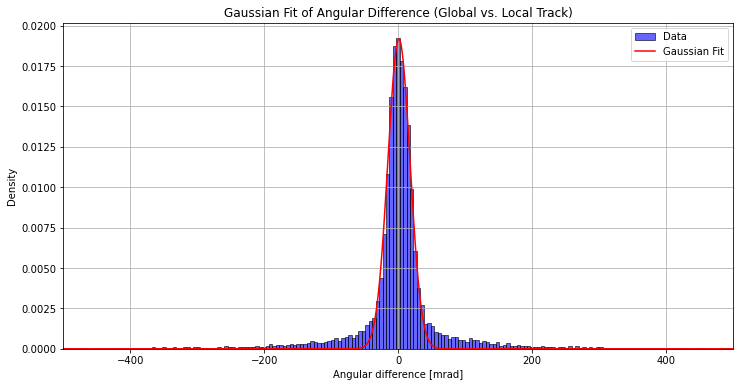

In [50]:
# merge local and global results into one DataFrame
global_vs_local_df = glob_results.merge(result_local_df[result_local_df["chamber"] == 2], on="ORBIT", suffixes=("_global", "_local"))
# compute angular difference in mrad
global_vs_local_df["angle_diff"] = 1000 * np.arctan((global_vs_local_df["slope_global"] - global_vs_local_df["slope_local"]) /(1 + global_vs_local_df["slope_global"] * global_vs_local_df["slope_local"]))

# gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# make histogram, compute bin centers
hist_values, bin_edges = np.histogram(global_vs_local_df["angle_diff"], bins=5_000, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
# perform fit
popt, _ = curve_fit(gaussian, bin_centers, hist_values, p0=[1, 0, 100])

# resulting fit parameters
A_fit, mu_fit, sigma_fit = popt
print(f"Gaussian Fit Parameters:")
print(f"  Mean (μ): {mu_fit:.2f} mrad")
print(f"  Standard Deviation (σ): {sigma_fit:.2f} mrad")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(global_vs_local_df["angle_diff"], bins=500, density=True, alpha=0.6, color='blue', edgecolor='black', label="Data")
ax.plot(bin_centers, gaussian(bin_centers, *popt), 'r-', label="Gaussian Fit")
ax.set_xlabel("Angular difference [mrad]")
ax.set_ylabel("Density")
ax.set_title("Gaussian Fit of Angular Difference (Global vs. Local Track)")
ax.legend()
plt.grid(True)
plt.xlim(-500, 500)
plt.show()

In [51]:
# Close the client and the cluster 
# (free port 8787 on scheduler machine)
client.close()
cluster.close()